## **ENERGY CONSUMPTION TIME SERIES**
### **NAME**: EDWARD TAN YUAN CHONG

### **IMPORT MODULES**

Modules such as tqdm and itertools are also required during hyperparameter tuning.

In [1]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# Ignore warnings
warnings.filterwarnings(action='ignore')
# Set seaborn style
sns.set(font='Century Gothic')
# Muted color palette
muted = sns.color_palette('muted')
color = [muted[2],muted[8],muted[0]]

c:\Users\edw4r\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<span style='color:#ee6666'><b>!</b> RUN THE CODE BELOW AGAIN TO ENSURE NO WARNINGS SHOW UP <b>!</b></span>

In [2]:
# Ignore warnings
warnings.filterwarnings(action='ignore')

## <b>CONTENT
<span style='font-size:24px;'>

<b>1. INTRODUCTION

<b>2. EXPLORATORY DATA ANALYSIS [EDA]

<b>3. FEATURE ENGINEERING

<b>4. TIME SERIES MODEL SELECTION

<b>5. HYPERPARAMETER TUNING

<b>6. TIME SERIES FORECASTING

<b>7. CONCLUSION
</span>

## **1. INTRODUCTION** <a class="anchor" id="intro"></a>

**DATASET**: energy_consumption.csv

**INFORMATION OF DATASET**: The dataset includes information of energy consumption, consisting of gas, electricity and water consumption of the first day of every month from 1990 to 2023 Janurary.

**TASK**: Train a time series model to forecast the gas, electricity and water consumption in the future.


### **IMPORT DATASET**
Ensure to make index column of the dataframe to the time series variable, DATE.

In [3]:
# Import energy consumption dataset
energy = pd.read_csv("./Energy Consumption Dataset.csv",index_col='DATE')
print('Shape of Dataset: ' + str(energy.shape))

Shape of Dataset: (397, 3)


### **UNDERSTANDING DATASET**
This section includes some feature engineering as well.


In [4]:
energy.head(5)

Gas Consumption (tons)  Electricity Consumption (MWh)  \
DATE                                                              
1/1/1990                    18.0                          725.1   
1/2/1990                    15.8                          706.7   
1/3/1990                    17.3                          624.5   
1/4/1990                    18.9                          574.7   
1/5/1990                    22.0                          553.2   

          Water Consumption (tons)  
DATE                                
1/1/1990                     548.8  
1/2/1990                     640.7  
1/3/1990                     511.1  
1/4/1990                     515.3  
1/5/1990                     488.4

In [5]:
energy.tail(5)

Gas Consumption (tons)  Electricity Consumption (MWh)  \
DATE                                                               
1/9/2022                     27.7                          986.2   
1/10/2022                    31.8                          936.1   
1/11/2022                    31.0                          973.4   
1/12/2022                    32.4                         1147.2   
1/1/2023                     31.3                         1294.0   

           Water Consumption (tons)  
DATE                                 
1/9/2022                      513.3  
1/10/2022                     373.1  
1/11/2022                     343.9  
1/12/2022                     348.3  
1/1/2023                      260.2

We can see that there are columns such as Gas Consumption in tons, Electricity Consumption in MWh, and Water Consumption in tons, with a time series variable of Date, ranging from 1990 to 2023. The time series variable is also identified to be the **first day** of **every month**.

In [6]:
# Rename DATE to Date to ensure consistency in column names
energy.index.name = 'Date'

In [7]:
# .describe() on dataset
energy.describe()

Gas Consumption (tons)  Electricity Consumption (MWh)  \
count              397.000000                     397.000000   
mean                23.785139                     888.472544   
std                  4.903452                     153.877594   
min                 11.600000                     553.200000   
25%                 20.200000                     771.100000   
50%                 23.500000                     897.800000   
75%                 27.900000                    1005.200000   
max                 46.000000                    1294.000000   

       Water Consumption (tons)  
count                397.000000  
mean                 484.953652  
std                  133.908863  
min                   44.400000  
25%                  384.400000  
50%                  487.400000  
75%                  580.200000  
max                  811.000000

We can see that all the values of every column are positive. Not only that, we can see that the range of values are not that large, and hence for models we would likely utilize **additive** models over multiplicative models.

In [8]:
# Check for missing values
print("Number of missing values:\n" + str(energy.isnull().sum()))

Number of missing values:
Gas Consumption (tons)           0
Electricity Consumption (MWh)    0
Water Consumption (tons)         0
dtype: int64


In [9]:
# Check for duplicate rows
print("Number of duplicate rows: " + str(energy.duplicated().sum()))

Number of duplicate rows: 0


In [10]:
# Check datatypes
print("Datatypes of each column:\n" + str(energy.dtypes) + '\n\nDatatype of index column, Date: ' + str(energy.index.dtype))

Datatypes of each column:
Gas Consumption (tons)           float64
Electricity Consumption (MWh)    float64
Water Consumption (tons)         float64
dtype: object

Datatype of index column, Date: object


We can see that there are no missing values and no duplicate rows, however, the datatype of the index, DATE, is object. Hence, we should change its datatype to datetime64 instead.

In [11]:
# Convert datatype of DATE from object to datetime64
energy.index = pd.to_datetime(energy.index,dayfirst=True)
# Set frequency of date
energy = energy.asfreq('MS')
# Check datatypes again
print("Datatypes of index column, Date:\n" + str(energy.index.dtype))

Datatypes of index column, Date:
datetime64[ns]


## **2. EXPLORATORY DATA ANALYSIS [EDA]**

**FUNCTION(S) FOR EDA**

In [12]:
# Import modules needed
from statsmodels.tsa.seasonal import seasonal_decompose
# Seasonal Decomposition Plot Function
def seasonal_plot(data,column,col_pal):
    decomposition = seasonal_decompose(data[column], model='additive', period=12)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid
    decomposed_df = pd.DataFrame({'Observed':data[column],'Trend': trend, 'Seasonal': seasonal, 'Residual': residual}, index=data.index)
    fig,axs = plt.subplots(4,1,figsize=(16,8))
    labels = ['Observed','Trend','Seasonal']
    axs[3].axhline()
    sns.scatterplot(data=decomposed_df['Residual'],ax=axs[3],color=col_pal,zorder=2)
    for x in range(len(labels)):
        sns.lineplot(data=decomposed_df[labels[x]],ax=axs[x],linewidth=2,color=col_pal)
    fig.suptitle('Seasonal Decomposition of ' + column,y=0.92)
    

### **CHART 1: DISTRIBUTION OF GAS,ELECTRICITY AND WATER CONSUMPTION**

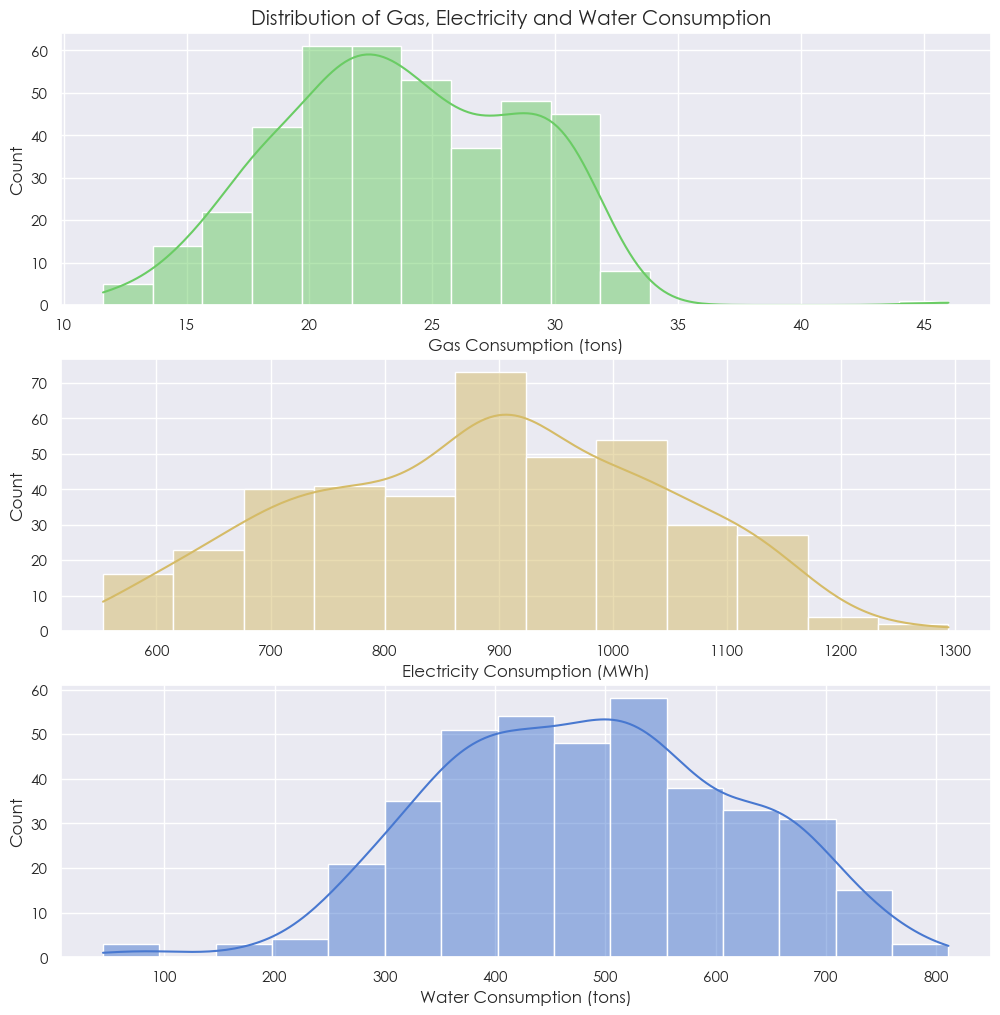

--------------Skewness of Features--------------
Gas Consumption: 0.1141639777427284
Electricity Consumption: -0.07311710152688564
Water Consumption: -0.0627184384515255


In [13]:
fig,axs = plt.subplots(3,1,figsize=(12,12))
count = 0
cols = energy.columns
for x in cols:
    sns.histplot(energy[x],ax=axs[count],color=color[count],kde=True)
    count += 1
fig.suptitle("Distribution of Gas, Electricity and Water Consumption",y=0.9)
plt.show()
print("--------------Skewness of Features--------------\nGas Consumption: " + str(energy['Gas Consumption (tons)'].skew()) + "\nElectricity Consumption: " + str(energy['Electricity Consumption (MWh)'].skew()) + "\nWater Consumption: " + str(energy['Water Consumption (tons)'].skew()))

**ANALYSIS OF CHART 1:**

From chart 1, we can see that generally, every column is normally distributed, with gas consumption being slightly positively-skewed with a skewness of 0.1.

### **CHART 2: GAS, ELECTRICITY, AND WATER CONSUMPTION FROM 1990 TO 2023**

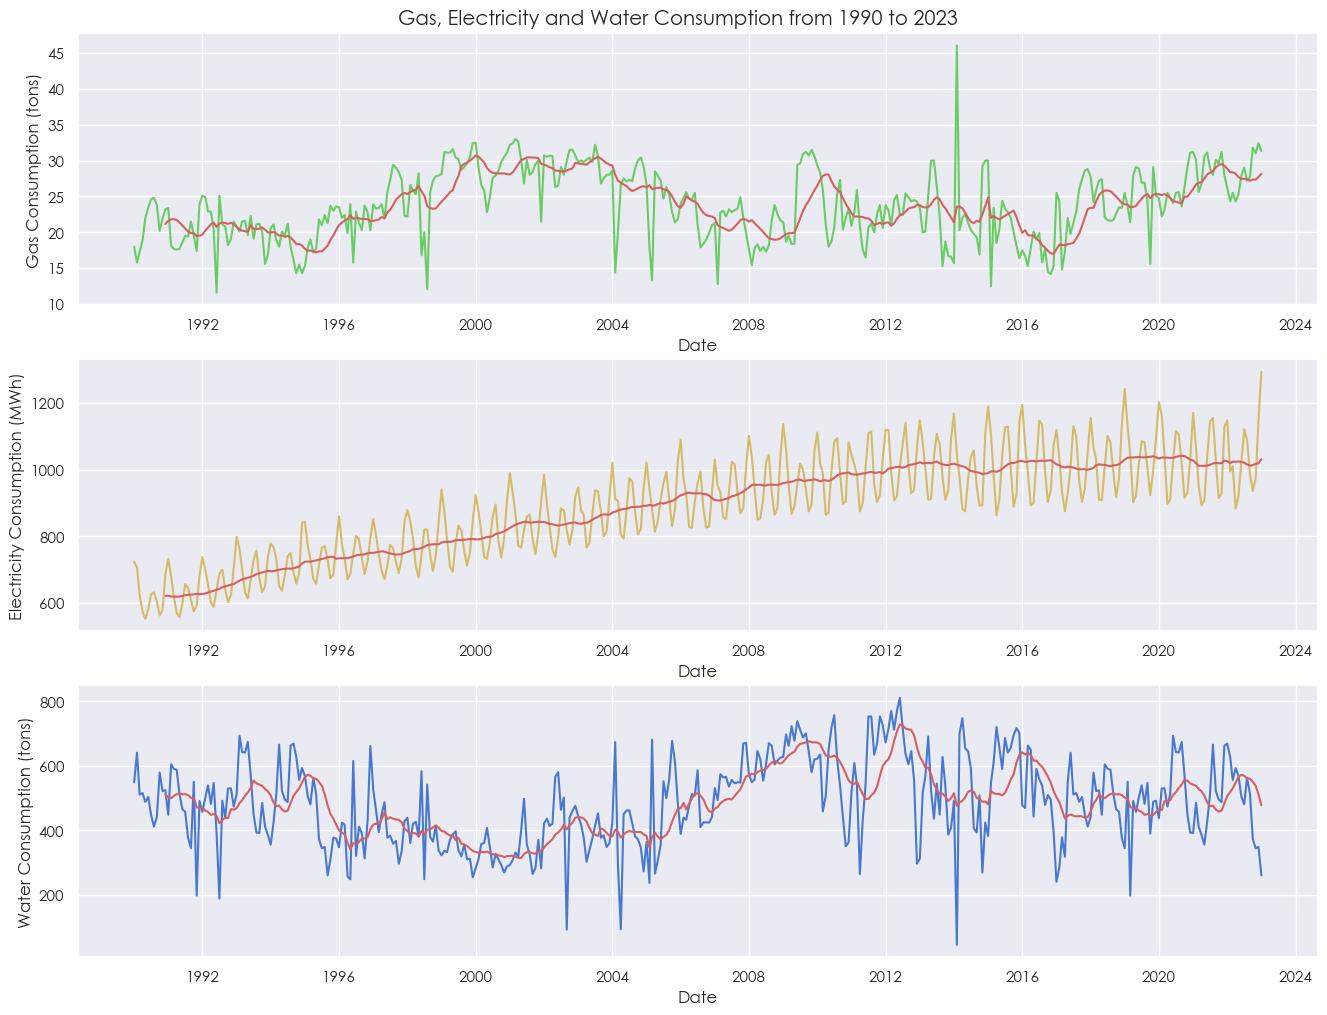

In [14]:
fig,axs = plt.subplots(3,1,figsize=(16,12))
count = 0
for x in energy.columns:
    sns.lineplot(x=energy.index,y=energy[x],ax=axs[count],color=color[count])
    sns.lineplot(energy[x].rolling(window=12).mean(),ax=axs[count],color=muted[3]) # Plot rolling statistics [Moving Average]
    count += 1
fig.suptitle("Gas, Electricity and Water Consumption from 1990 to 2023",y=0.9)
plt.show()

**ANALYSIS OF CHART 2:**

From chart 2, we can see that for Gas and Water Consumption, there is no consistent trend in its data, and it seems to be rather stationary, likely due to seasonal changes affecting supply and demand, and the consumption of water and gas may be consistent leading to no visible trends in its consumptions.
Whilst for Electricity Consumption, we can see an increasing trend in consumption from 1991 to 2023, likely due to technological advancements and economic growth, leading to industrial expansions hence more electricity used, and possibly more reasons.

### **<span style='color:#6acc64'>CHART 3: SEASONAL DECOMPOSITION OF GAS CONSUMPTION (TONS)</span>**

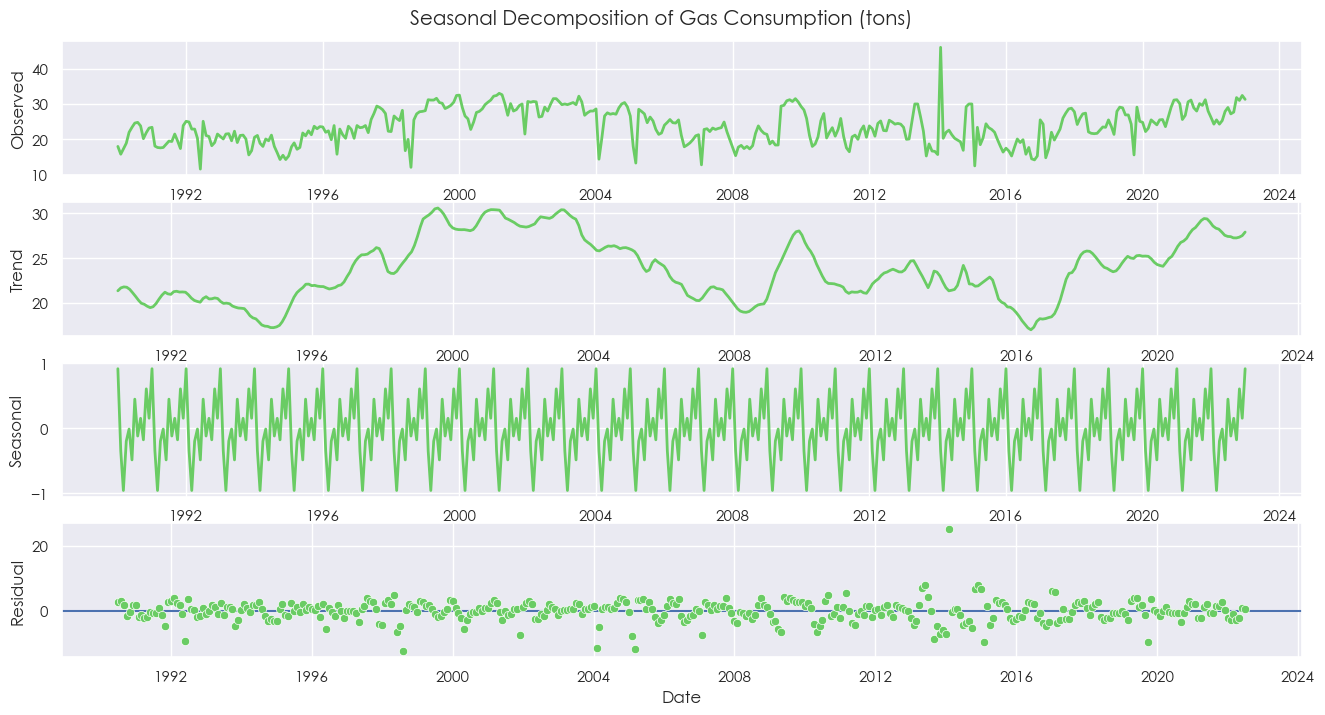

In [15]:
seasonal_plot(energy,'Gas Consumption (tons)',color[0])

<span style='color:#6acc64'>**ANALYSIS OF CHART 3:**</span>

From the seasonal decomposition of gas consumption, we observed that:
- There isn't really much of a trend in gas consumption over the years, thus likely stationary
- There is a yearly seasonality trend -> seasonal_order m = 12
- Most residuals do not deviate much from the zero line and there are no patterns in the residuals

### **<span style='color:#d7c077'>CHART 4: SEASONAL DECOMPOSITION OF ELECTRICITY CONSUMPTION (MWH)</span>**

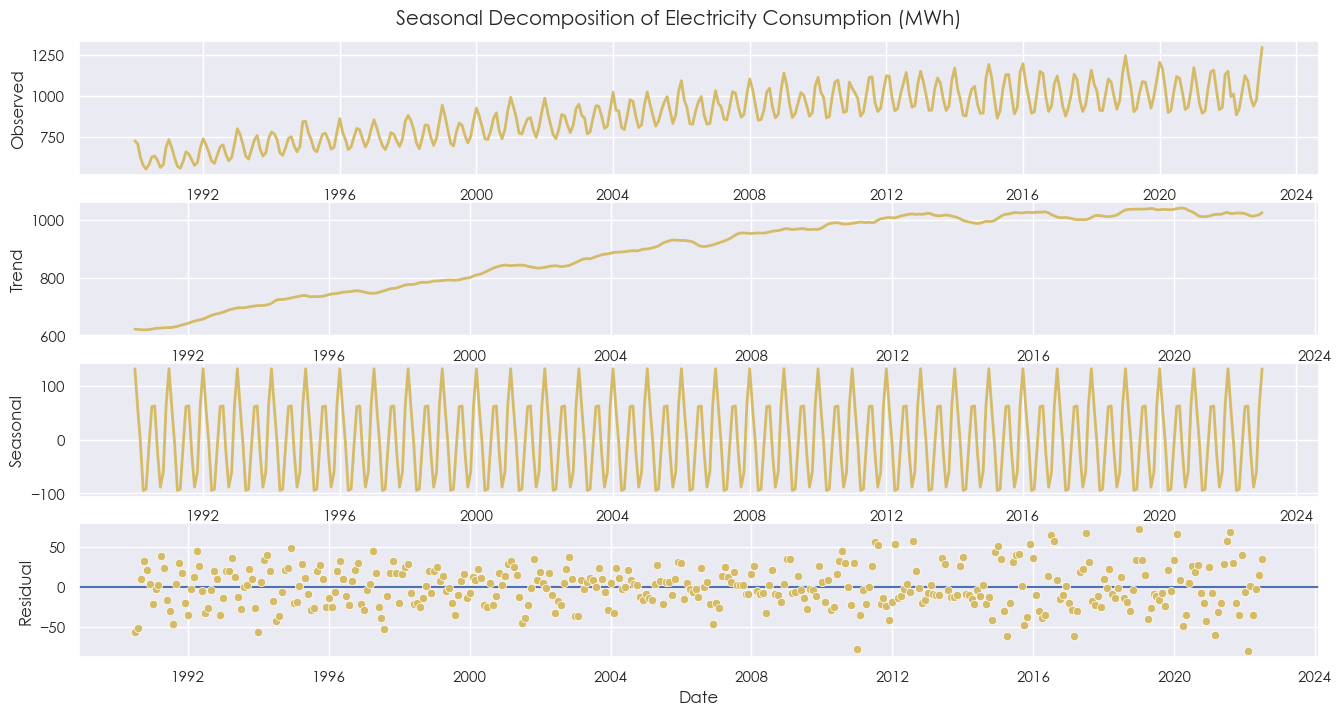

In [16]:
seasonal_plot(energy,'Electricity Consumption (MWh)',color[1])

<span style='color:#d7c077'>**ANALYSIS OF CHART 4:**</span>

From the seasonal decomposition of electricity consumption, we observed that:
- There is a clear increasing trend of electricity consumption over the years, very likely non-stationary
- There is a yearly seasonality trend -> seasonal_order m = 12
- Most residuals do deviate from the zero line but there are no patterns in the residuals

### **<span style='color:#4878d0'>CHART 5: SEASONAL DECOMPOSITION OF WATER CONSUMPTION (TONS)</span>**

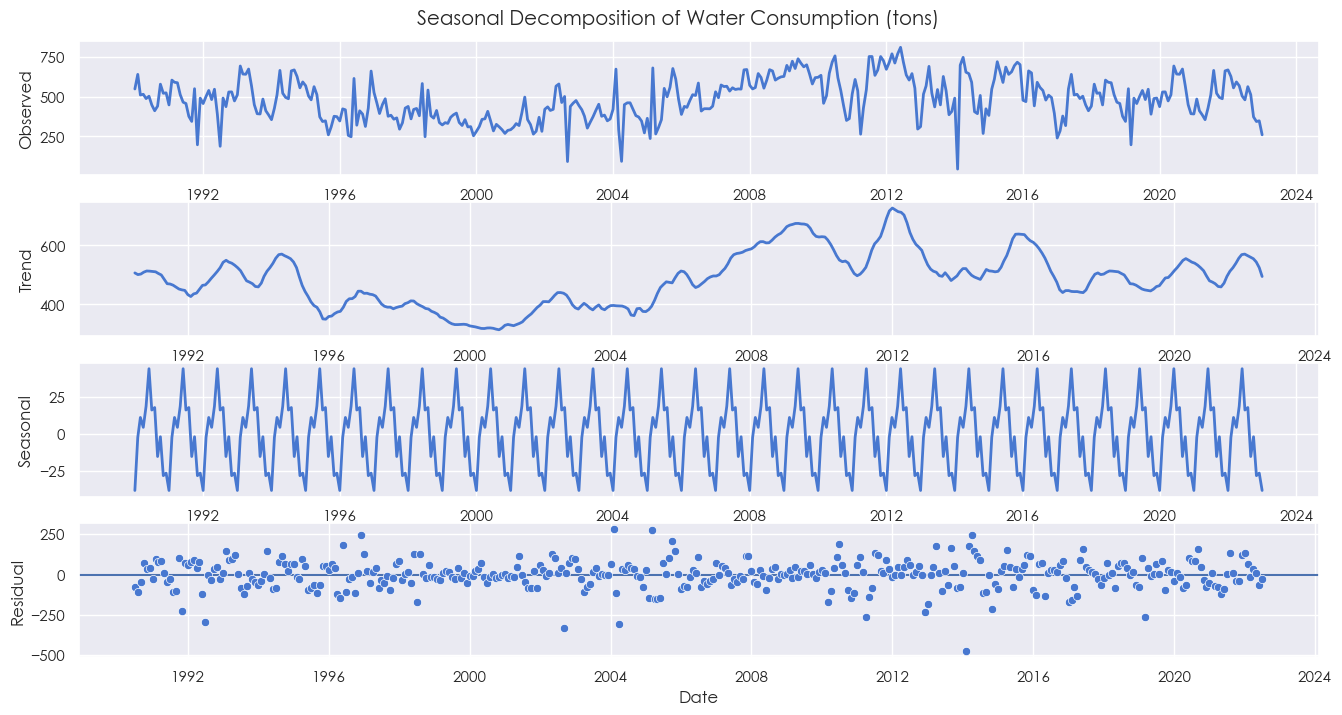

In [17]:
seasonal_plot(energy,'Water Consumption (tons)',color[2])

<span style='color:#4878d0'>**ANALYSIS OF CHART 5:**</span>

From the seasonal decomposition of water consumption, we observed that:
- The trend is rather stationary and there is no consistent trend
- There is a yearly seasonality trend -> seasonal_order m = 12
- Quite a few residuals deviate from the zero line but there are no patterns in the residuals

### **CHART 6: BOXPLOT OF ENERGY CONSUMPTION DATASET FEATURES**

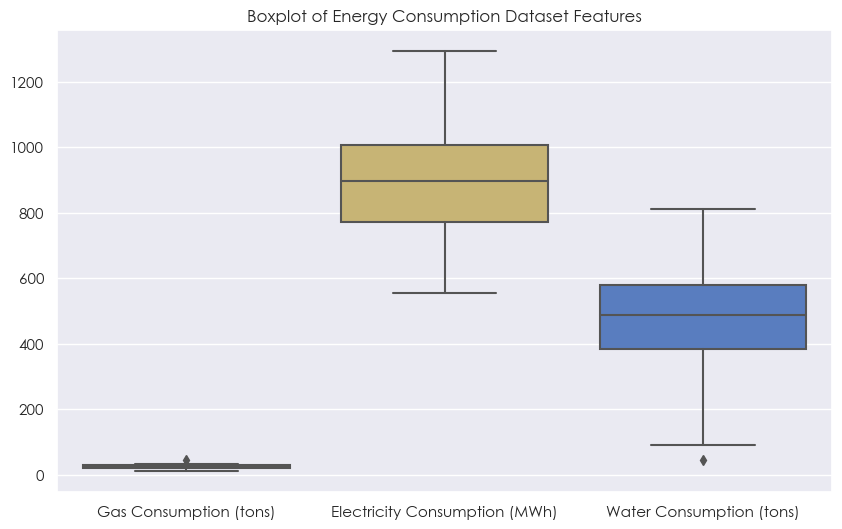

In [18]:
fig,ax = plt.subplots(figsize=(10,6))
bxplot = sns.boxplot(energy,ax=ax,palette=color).set(title='Boxplot of Energy Consumption Dataset Features')
plt.show()

**ANALYSIS OF CHART 6:**

From the boxplot, we can see that there are very little outliers, hence we would not need to perform outlier removal as they would not significantly impact the model's performance.

This also gives us a better comparison of the range of values for each feature, which shows us that the range for all features are rather small, also proven by the .describe() function earlier, reinforcing that the model used would likely be additive instead of multiplicative.

### **CHART 7: LAG PLOT OF ENERGY CONSUMPTION DATASET FEATURES**

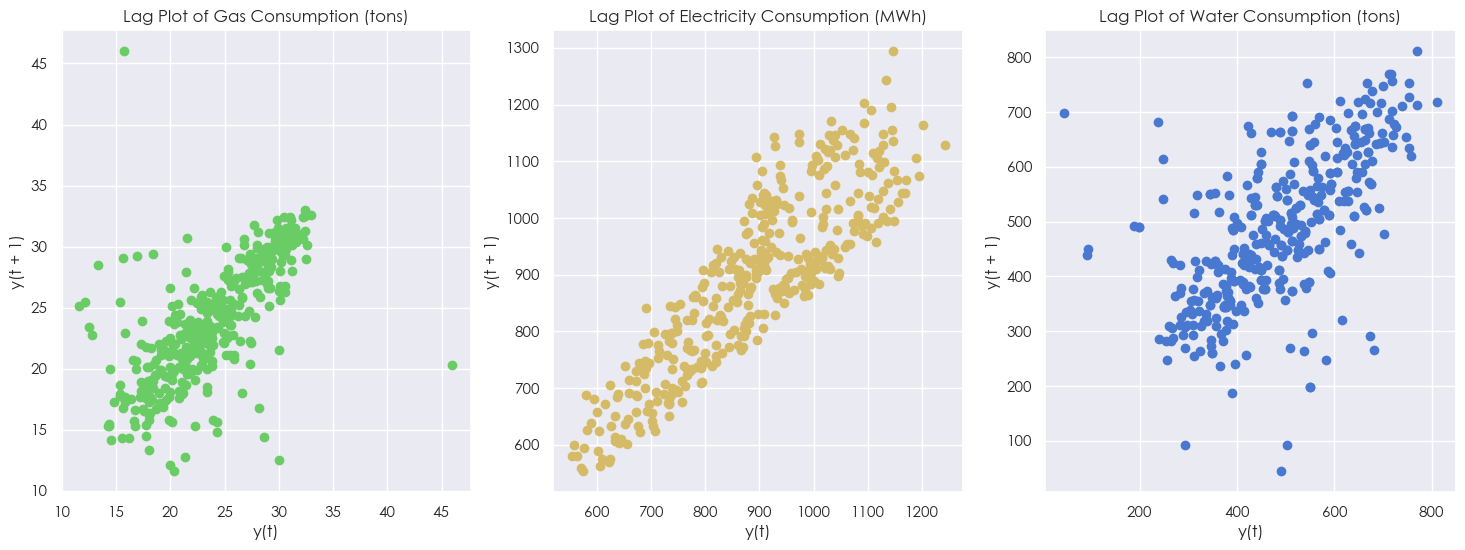

In [19]:
from pandas.plotting import lag_plot
# Ignore warning given from *c* hyperparameter in lag_plot function
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
fig,axs = plt.subplots(1,3,figsize=(18,6)) 
for x in range(len(cols)):
    lag_plot(series=energy[cols[x]],ax=axs[x], c=color[x])
    axs[x].set_title('Lag Plot of ' + cols[x])


**ANALYSIS OF CHART 7:**

From chart 7, we can see that for each feature in the dataset, there is a strong positive autocorrelation in the data points, where high values tend to follow high values or low values tend to follow low values, indicating a systematic pattern of values for each feature's data.

### **CHART 8: CORRELATION HEATMAP BETWEEN EACH CONSUMPTION**

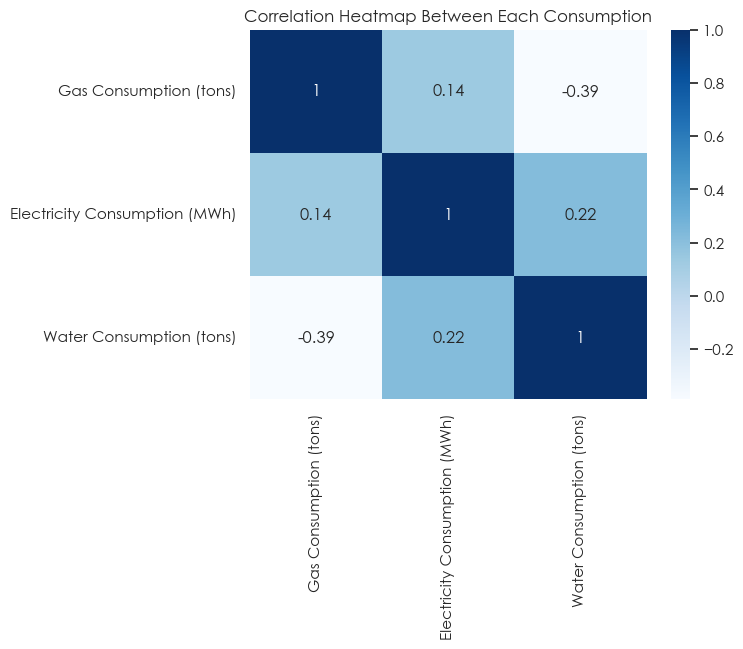

In [20]:
sns.heatmap(energy.corr(),cmap='Blues',annot=True).set(title='Correlation Heatmap Between Each Consumption')
plt.show()

**ANALYSIS OF CHART 8:**

From the correlation heatmap, we can see that the time series variables of each consumption are NOT interrelated as they have weak linear relationships with one another. 

## **3. FEATURE ENGINEERING**

### **CHECK STATIONARITY WITH AUGMENTED DICKEY-FULLER (ADF) TEST**

Stationarity of each feature is checked with the Augmented Dickey-Fuller (ADF) Test, where if P-value > 0.05, we cannot reject the null hypothesis, and hence the time series is non-stationary, and we would have to make the time series stationary through differencing. Otherwise if P-value < 0.05, null hypothesis is rejected and the time series is stationary. 

In [21]:
# Import modules
from statsmodels.tsa.stattools import adfuller
# Loop each column to print ADF Test results
for col in cols:
    adftest = adfuller(energy[col])
    print("x" + "-"*20 + 'ADF Test for ' + col + "-"*20 + "x")
    result = ['Test Statistic','P-value','Lags Used','No. Of Observations',['Critical Value [1%]', 'Critical Value [5%]', 'Critical Values [10%]'],'AIC']
    crit = ['1%','5%','10%']
    for x in range(len(result)):
        if x == 4:
            for i in range(len(result[4])):
                print(result[x][i] + ": " + str(adftest[x][crit[i]]))
        else:
            print(result[x] + ": " + str(adftest[x]))
    print(len("x" + "-"*33 + col + "-"*20 + "x")*'-' + "\n")


x--------------------ADF Test for Gas Consumption (tons)--------------------x
Test Statistic: -3.4043743333182728
P-value: 0.01081065170706051
Lags Used: 6
No. Of Observations: 390
Critical Value [1%]: -3.4472291365835566
Critical Value [5%]: -2.8689795375849223
Critical Values [10%]: -2.5707330834976987
AIC: 2039.9854463616298
-----------------------------------------------------------------------------

x--------------------ADF Test for Electricity Consumption (MWh)--------------------x
Test Statistic: -2.256980549592542
P-value: 0.18621802300336632
Lags Used: 15
No. Of Observations: 381
Critical Value [1%]: -3.4476305904172904
Critical Value [5%]: -2.869155980820355
Critical Values [10%]: -2.570827146203181
AIC: 3586.2333280905104
------------------------------------------------------------------------------------

x--------------------ADF Test for Water Consumption (tons)--------------------x
Test Statistic: -4.684845541682444
P-value: 8.984549388336973e-05
Lags Used: 4
No. Of Obse

From the Augmented Dickey-Fuller Test, we can see that only Electricity Consumption (MWh) is non-stationary as its P-Value = 0.186 > 0.05, whilst the other two columns are stationary. Hence, we would have to difference the Electricity Consumption column in order to make it stationary.

### **DIFFERENCING ELECTRICITY CONSUMPTION (MWH)**

For k_diff hyperparameter, it was set to 1 for a first order of differencing as the first order of differencing was enough to make the time series stationary, hence second order of differencing was not necessary.

ADF Test was used again to check stationarity before and after differencing. However, statistical test was not implemented as it is less reliable compared to the ADF Test.

x-----------P-Value of ADF Test-----------x
Before Differencing: 0.18621802300336632
After Differencing: 4.079770743785098e-10
-------------------------------------------


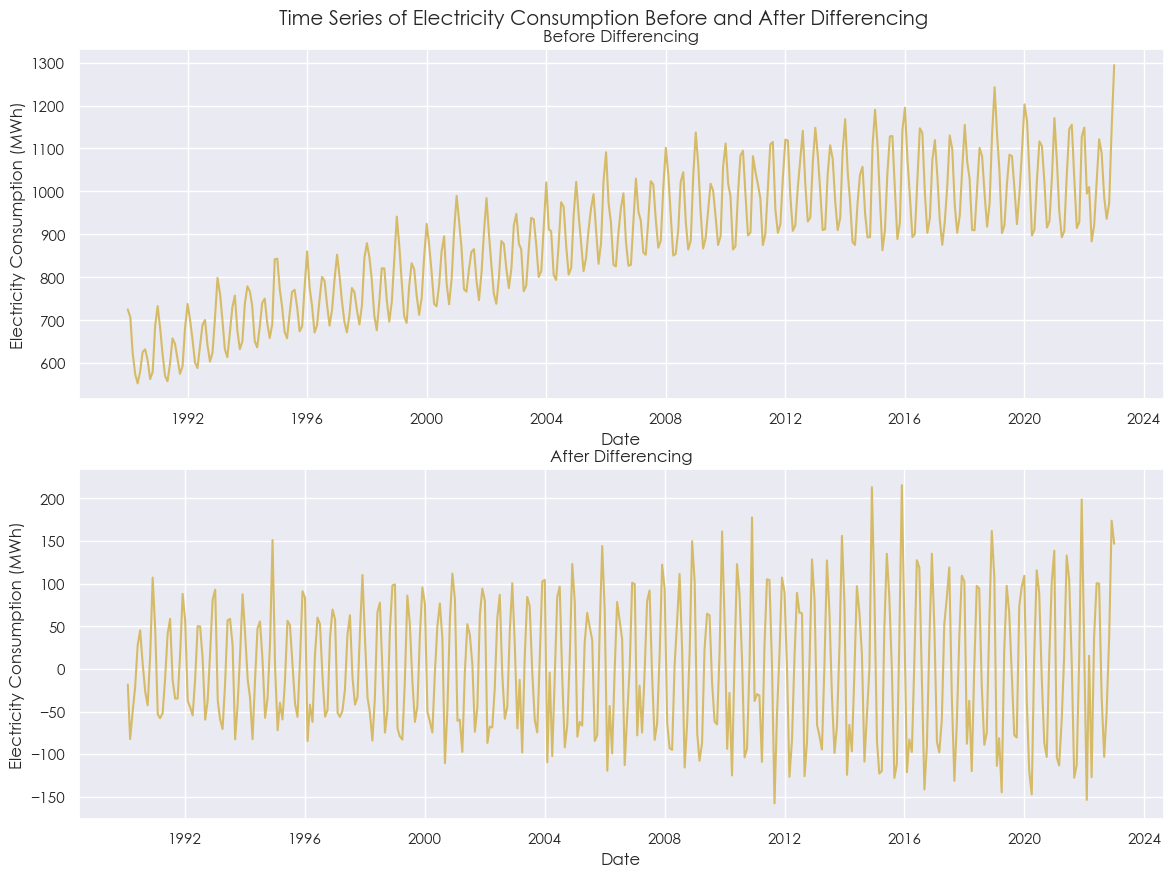

In [22]:
# Import modules
from statsmodels.tsa.statespace.tools import diff
# Perform Differencing
elect_diff = diff(energy['Electricity Consumption (MWh)'],k_diff=1)
# Check stationary with ADF Test
print('x-----------P-Value of ADF Test-----------x\nBefore Differencing: ' + str(adfuller(energy['Electricity Consumption (MWh)'])[1]) + '\nAfter Differencing: ' + str(adfuller(elect_diff)[1]) + "\n" + "-"*len("x-----------P-Value of ADF Test-----------x"))
# # Use summary statistics to check [NOT IMPLEMENTED]
# X1 = elect_diff.iloc[:len(elect_diff)//2]
# X2 = elect_diff.iloc[len(elect_diff)//2:]
# print(f'\n-----------Statistical Test-----------\nGroup 1 Mean = {X1.mean():.2f}, Group 2 Mean = {X1.mean():.2f}, \nGroup 1 Variance = {X1.var():.2f}, Group 2 Variance = {X2.var():.2f}')
# Plot time series to view differencing results
fig,axs = plt.subplots(2,1,figsize=(14,10))
sns.lineplot(energy['Electricity Consumption (MWh)'],ax=axs[0],color=color[1]).set(title='Before Differencing')
sns.lineplot(elect_diff,ax=axs[1],color=color[1]).set(title='After Differencing')
fig.suptitle(t='Time Series of Electricity Consumption Before and After Differencing',y=0.92)
plt.show()

We can see that through differencing, we were able to make the time series of Energy Consumption (MWh) stationary, shown by the P-value < 0.05 and the lineplot, allowing our time series models later on to be able to work effectively and produce reliable results, if necessary.

### **TRAIN TEST SPLIT**

Split_date was set in way such that when the data is split, the training would be earlier dates containing around 80% of the dates, and test would be later dates containing around 20% of the dates.


**FUNCTION(S) FOR TRAIN TEST SPLIT**

In [23]:
# Function to manually train test split
def train_test(data,split_date):
    train = data.loc[data.index < split_date]
    test = data.loc[data.index >= split_date]   
    return train,test

In [24]:
# Variable for split_date
import math
split_date = energy.iloc[math.ceil(len(energy)*0.8)].name
print("80% of the dataset would be before this date: " + str(split_date))
# Gas Consumption Train Test Split
gas_train_,gas_test = train_test(data=energy['Gas Consumption (tons)'],split_date=split_date) # gas_train_ with _ at the end as this is NOT the final train data
# Electricity Consumption Train Test Split
electricity_train_,electricity_test = train_test(data=energy['Electricity Consumption (MWh)'],split_date=split_date)
# Water Consumption Train Test Split
water_train_,water_test = train_test(data=energy['Water Consumption (tons)'],split_date=split_date)
# Check data length
# Header variable
gas_title = 'Gas Consumption Train and Test Data Length:'
elect_title = 'Electricity Consumption Train and Test Data Length:'
water_title = 'Water Consumption Train and Test Data Length:'
# Printing lengths
print('\n' + gas_title + '\n' + '-'*len(gas_title) + '\nTrain data: ' + str(len(gas_train_)) + '\nTest data: ' + str(len(gas_test)) + '\n' +   '-'*len(gas_title))
print('\n' + elect_title + '\n' + '-'*len(elect_title) + '\nTrain data: ' + str(len(electricity_train_)) + '\nTest data: ' + str(len(electricity_test)) + '\n' + '-'*len(elect_title) )
print('\n' + water_title + '\n' + '-'*len(water_title) + '\nTrain data: ' + str(len(water_train_)) + '\nTest data: ' + str(len(water_test)) + '\n' +   '-'*len(water_title))

80% of the dataset would be before this date: 2016-07-01 00:00:00

Gas Consumption Train and Test Data Length:
-------------------------------------------
Train data: 318
Test data: 79
-------------------------------------------

Electricity Consumption Train and Test Data Length:
---------------------------------------------------
Train data: 318
Test data: 79
---------------------------------------------------

Water Consumption Train and Test Data Length:
---------------------------------------------
Train data: 318
Test data: 79
---------------------------------------------


The train data length should be 318 whilst test data length should be 79.

The lengths of the train and test sets are correct.

<span style='font-size:20px;'> **TRAIN VALIDATION SPLIT**

We would also require a validation set for hyperparameter tuning, hence we would perform train test split on train set only again, to obtain a validation set. 

Since all the lengths of the train sets for each column are the same, the same date can be utilized as the split date.

In [25]:
import math
validation_split_date = electricity_train_.index[math.ceil(len(electricity_train_)*0.8)]
print("80% of the dataset would be before this date: " + str(validation_split_date))
# Gas train validation split
gas_train, gas_val = train_test(data=gas_train_,split_date=validation_split_date)
# Electricity train validation split
electricity_train, electricity_val = train_test(data=electricity_train_,split_date=validation_split_date)
# Water train validation split
water_train, water_val = train_test(data=water_train_,split_date=validation_split_date)
# Check data length
# Header variable
gas_title = 'Gas Consumption Train and Validation Data Length:'
elect_title = 'Electricity Consumption Train and Validation Data Length:'
water_title = 'Water Consumption Train and Validation Data Length:'
# Printing lengths
print('\n' + gas_title + '\n' + '-'*len(gas_title) + '\nTrain data: ' + str(len(gas_train)) + '\nValidation data: ' + str(len(gas_val)) + '\n' +   '-'*len(gas_title))
print('\n' + elect_title + '\n' + '-'*len(elect_title) + '\nTrain data: ' + str(len(electricity_train)) + '\nValidation data: ' + str(len(electricity_val)) + '\n' + '-'*len(elect_title) )
print('\n' + water_title + '\n' + '-'*len(water_title) + '\nTrain data: ' + str(len(water_train)) + '\nValidation data: ' + str(len(water_val)) + '\n' +   '-'*len(water_title))

80% of the dataset would be before this date: 2011-04-01 00:00:00

Gas Consumption Train and Validation Data Length:
-------------------------------------------------
Train data: 255
Validation data: 63
-------------------------------------------------

Electricity Consumption Train and Validation Data Length:
---------------------------------------------------------
Train data: 255
Validation data: 63
---------------------------------------------------------

Water Consumption Train and Validation Data Length:
---------------------------------------------------
Train data: 255
Validation data: 63
---------------------------------------------------


The train and validation data length should be 255 and 63 respectively. 

The lengths of the train, validation and test sets are correct, with a 65-15-20 split (validation data was 80% of training data which was 80% of entire dataset was used). With these, we will now move on with time series model selection.

## **4. TIME SERIES MODEL SELECTION**

In order to determine which time model is best for each feature of consumption, we would test each model's ability to predict the test data based off train data through 5-fold cross-validation and select model's that perform better in terms of evaluation methods before we perform time series forecasting. Cross-validation was done in order to prevent data leakage when using test set to evaluate the models.

**Evaluation Methods:**
- **Visual Inspection from the 5-fold cross-validation [FOCUS]**
- Mean Absolute Error (MAE)
- **Mean Absolute Percentage Error (MAPE) [FOCUS]**
- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- R-Squared
- Explained Variance 

**Time Series Models Tested:**
- Holt Winter's Exponential Smoothing
- ARIMA
- SARIMAX

**How does Diagnostic Plot show that the model is a good fit?**
- Standardized residual plot -> No obvious patterns in the residuals
- Histogram plus KDE estimate plot -> KDE curve should be very similar/have a normal distribution [Compare KDE to N(0,1)]
- Normal Q-Q plot -> Most data points should lie on the straight line
- Correlogram -> 95% of correlations for lag greater than zero should not be significant -> Lags should not lie outside the confidence band (shaded area)



<span style='color:#ee6666'> <b>!</b> Ensure that the model preparation is ran before running the code block for each model evaluation. <b>!</b> 

Through experimentation, I realised that when I used only train dataset to split into folds for cross-validation, Exponential Smoothing had the best MAPE and fit the best for EVERY consumption compared to ARIMA or SARIMAX, which was likely due to how small the training dataset is, hence I opted for a larger dataset, using the train + validation dataset for each consumption instead to split into folds for cross-validation.

**FUNCTIONS FOR MODEL SELECTION**

In [26]:
# Import modules needed
from sklearn import metrics
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from matplotlib.collections import PolyCollection, LineCollection

# Prediction results function
def predResult(test,predicted,modelName):
    # Variables
    pred_test = predicted[-len(test):] # Take last N elements similar to length of test dataset (N)
    mape = metrics.mean_absolute_percentage_error(test,pred_test)
    mae = metrics.mean_absolute_error(test, pred_test)
    mse = metrics.mean_squared_error(test, pred_test)
    rmse = np.sqrt(metrics.mean_squared_error(test, pred_test))
    r_square = metrics.r2_score(test, pred_test)
    mape = metrics.mean_absolute_percentage_error(test, pred_test)
    evar = metrics.explained_variance_score(test, pred_test)
    # Store results in dictionary to convert to dataframe format
    results = {modelName:[mae,mape,mse,rmse,r_square,evar]}
    return pd.DataFrame.from_dict(results,orient='index',columns=['MAE','MAPE','MSE','RMSE','R-SQUARED','EXPLAINED VARIANCE'])

# Cross validation for time series function 
def TimeSeriesCV(data,arimaOrder,sarimaxOrder,sarimaxSeasonalOrder,color): # Training + validation set used to CV
    # Empty dataframe to store evaluation metrics later on
    result_df = pd.DataFrame()
    # Number of folds
    num_folds = 5
    # Initialize TimeSeriesSplit with number of folds to be made
    tscv = TimeSeriesSplit(n_splits=num_folds)
    # Arrays to store each fold's test data and predictions
    test_list = []
    expo_pred_list, arima_pred_list, sarimax_pred_list = [],[],[]
    # Iterate each fold
    for train_index, test_index in tscv.split(data):
        train, test = data[train_index], data[test_index]
        # Instantiate and fit each model
        arima = ARIMA(endog=train,order=arimaOrder,freq='MS').fit()
        sarimax = SARIMAX(endog=train,order=sarimaxOrder,seasonal_order=sarimaxSeasonalOrder,freq='MS').fit()
        expo = ExponentialSmoothing(train,trend='add',seasonal='add',seasonal_periods=12,freq='MS',missing='raise').fit()
        # Make predictions on test for each model
        expo_pred = expo.forecast(len(test))
        arima_pred = arima.predict(start=min(test.index),end=max(test.index))
        sarimax_pred = sarimax.predict(start=min(test.index),end=max(test.index))
        # Evaluation Metrics Function
        expo_result = predResult(test,expo_pred,'Exponential Smoothing')
        arima_result = predResult(test,arima_pred,'ARIMA '  + str(arimaOrder))
        sarimax_result = predResult(test,sarimax_pred,'SARIMAX '  + str(sarimaxOrder) + "x" + str(sarimaxSeasonalOrder))
        # Append predictions to each list respectively
        expo_pred_list.append(expo_pred)
        arima_pred_list.append(arima_pred)
        sarimax_pred_list.append(sarimax_pred)
        # Append the fold's test data to the list
        test_list.append(test)
        # Concatenate each model's evaluation metrics dataframe to result_df
        result_df = pd.concat([result_df,expo_result,arima_result,sarimax_result])
    # Create subplots for each fold and each model (5 x 3)
    fig, axes = plt.subplots(num_folds,3, figsize=(20, 5*num_folds))
    # Variables
    all_pred_list = [expo_pred_list,arima_pred_list,sarimax_pred_list]
    model_names = ['Exponential Smoothing','ARIMA ' + str(arimaOrder),'SARIMAX ' + str(sarimaxOrder) + "x" + str(sarimaxSeasonalOrder)]
    # Loop each model
    for x in range(len(model_names)):
        predicted_values_list = all_pred_list[x]
        model_title = model_names[x]
        # Plot actual vs predicted for each fold
        for i in range(num_folds):
            ax = axes[i][x]
            actual_values = test_list[i]
            predicted_values = predicted_values_list[i]
            ax.plot(actual_values.index, actual_values, label='Actual', color=color)
            ax.plot(actual_values.index, predicted_values, label='Predicted', color='red')
            ax.set_title(f'{model_title} Fold {i+1}')
            ax.set_ylabel('Values')
            ax.legend()
    plt.tight_layout()
    plt.show()
    return result_df.groupby(level=0).mean().reindex(model_names)

# Obtain MAPE from SARIMAX (FOR HYPERPARAMETER TUNING)
def sarimax_result(train,val,order,seasonal_order,startPred,endPred):
    sarimax = SARIMAX(endog=train,order=order,seasonal_order=seasonal_order).fit(maxiter=10000)
    pred = sarimax.predict(start=startPred,end=endPred)
    return metrics.mean_absolute_percentage_error(val, pred)

# Function to plot ACF and PACF Plot
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
def acf_pacf_plot(data,name,col):
    fig,axs = plt.subplots(1,2,figsize=(16,6))
    plot_acf(data,title='Autocorrelation of ' + name,ax=axs[0],color=col)
    plot_pacf(data,title='Partial Autocorrelation of ' + name,ax=axs[1],method='ywm',color=col)
    # Change color of ACF and PACF plot
    for x in range(2):
        for item in axs[x].collections:
            # Change the color of the CI 
            if type(item)==PolyCollection:
                item.set_facecolor(col)
            # Change the color of the vertical lines
            if type(item)==LineCollection:
                item.set_color(col) 
    plt.show()

# Function to plot seasonal ACF Plot
def seasonal_acf_plot(data,name,col):
    fig,axs = plt.subplots()
    decomposition = seasonal_decompose(data[name], model='additive', period=12)
    seasonal = decomposition.seasonal
    plot_acf(seasonal,title='Seasonal Autocorrelation of ' + name,color=col,ax=axs)
    for item in axs.collections:
        # Change the color of the CI 
        if type(item)==PolyCollection:
            item.set_facecolor(col)
        # Change the color of the vertical lines
        if type(item)==LineCollection:
            item.set_color(col) 
    plt.show()

### **MODEL SELECTION <span style='color:#6acc64'>[GAS CONSUMPTION (TONS)]**

<p style='font-size:20px; color:#6acc64'> <b>MODEL PREPARATION </p>

**AUTOCORRELATION AND PARTIAL AUTOCORRELATION PLOT**

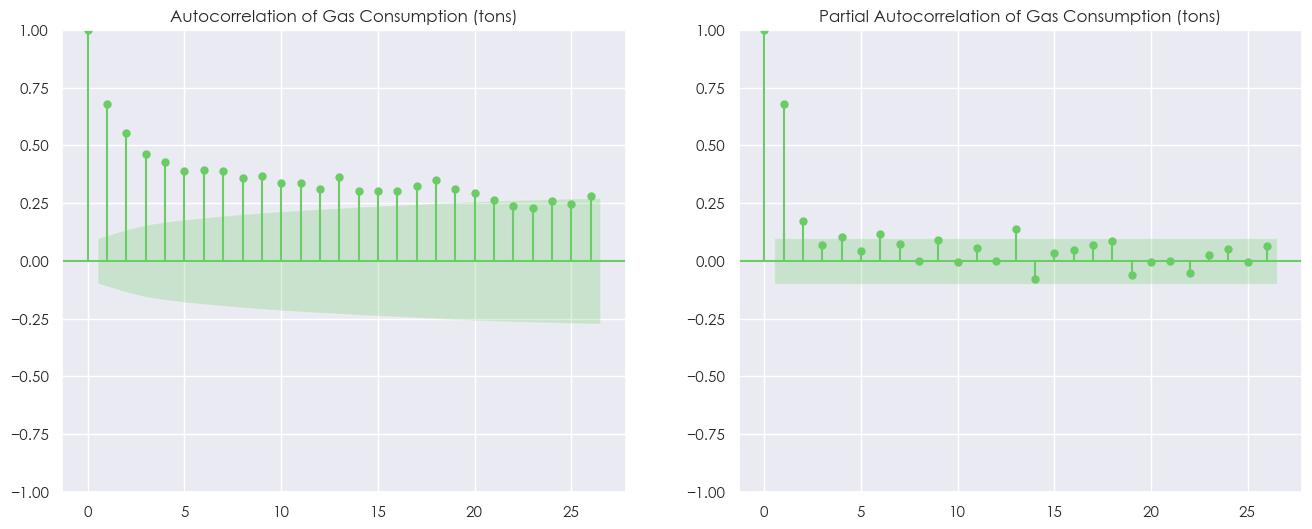

In [27]:
acf_pacf_plot(energy['Gas Consumption (tons)'],'Gas Consumption (tons)',color[0])

**SEASONAL AUTOCORRELATION PLOT**

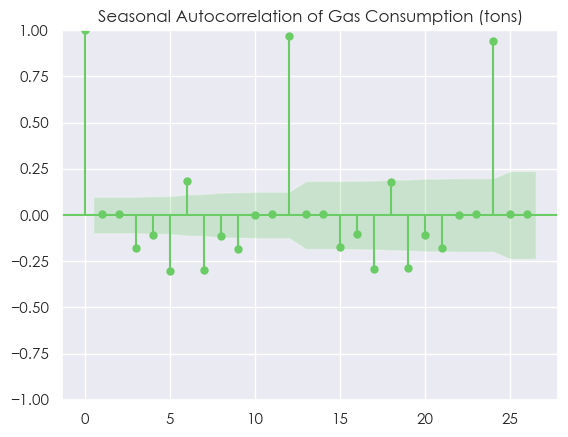

In [28]:
seasonal_acf_plot(energy,'Gas Consumption (tons)',color[0])

<p style='font-size:20px; color:#6acc64'><b>ANALYSIS OF SACF, ACF & PACF PLOT FOR GAS CONSUMPTION (TONS):</b></P>

From the ACF Plot, we can observe a gradual decay for the autocorrelation, showing a tail off, hence the series displays an AR signature.\

From the PACF Plot, we can observe that there is only a significant spike in correlation at lag 1 and lag 2, meaning that all the higher-order autocorrelations are effectively explained by the lag-2 autocorrelation. Hence an AR(2) model should be used.

**ARIMA order (p,d,q) for gas consumption**:

Autoregressive order (p) -> 2 | Explanation: Since the PACF plot showed that the last significant lag spike occured at lag-2, p=2.

Differencing order (d) -> 0 | Explanation: The data is stationary, hence no differencing was required, thus number of differences required is 0.

Moving Average order (q) -> 0 | Explanation: Since the ACF plot showed a gradual decay, q=0.

**ORDER:** (2,0,0)

From the seasonal autocorrelation (SACF) plot, we can see that there is a spike in autocorrelation at every 12th lag, confirming that there is a yearly seasonality trend, hence m = 12.

**SARIMAX seasonal order (P,D,Q,m) for gas consumption**:

**SEASONAL_ORDER:** ( , , , 12)

<span style='color:#6acc64'>**ARIMA**

ARIMA order was determined earlier to be (2,0,0), and frequency of time series data was identified to be the start of every month, thus freq='MS'.

In [29]:
# Variables needed
arimaOrder = (2,0,0)

<span style='color:#6acc64'>**SARIMAX**

Sarimax order was determined earlier to be (2,0,0). 

In [30]:
# Variables needed
sarimaxOrder = (2,0,0)
sarimaxSeasonalOrder = (1,1,1,12) # Seasonal Differencing, D, was set to 1 as we know that there is a seasonal pattern that has to be removed

<p style='font-size:20px;'><b>MODEL EVALUATION <span style='color:#6acc64'>[GAS CONSUMPTION (TONS)]

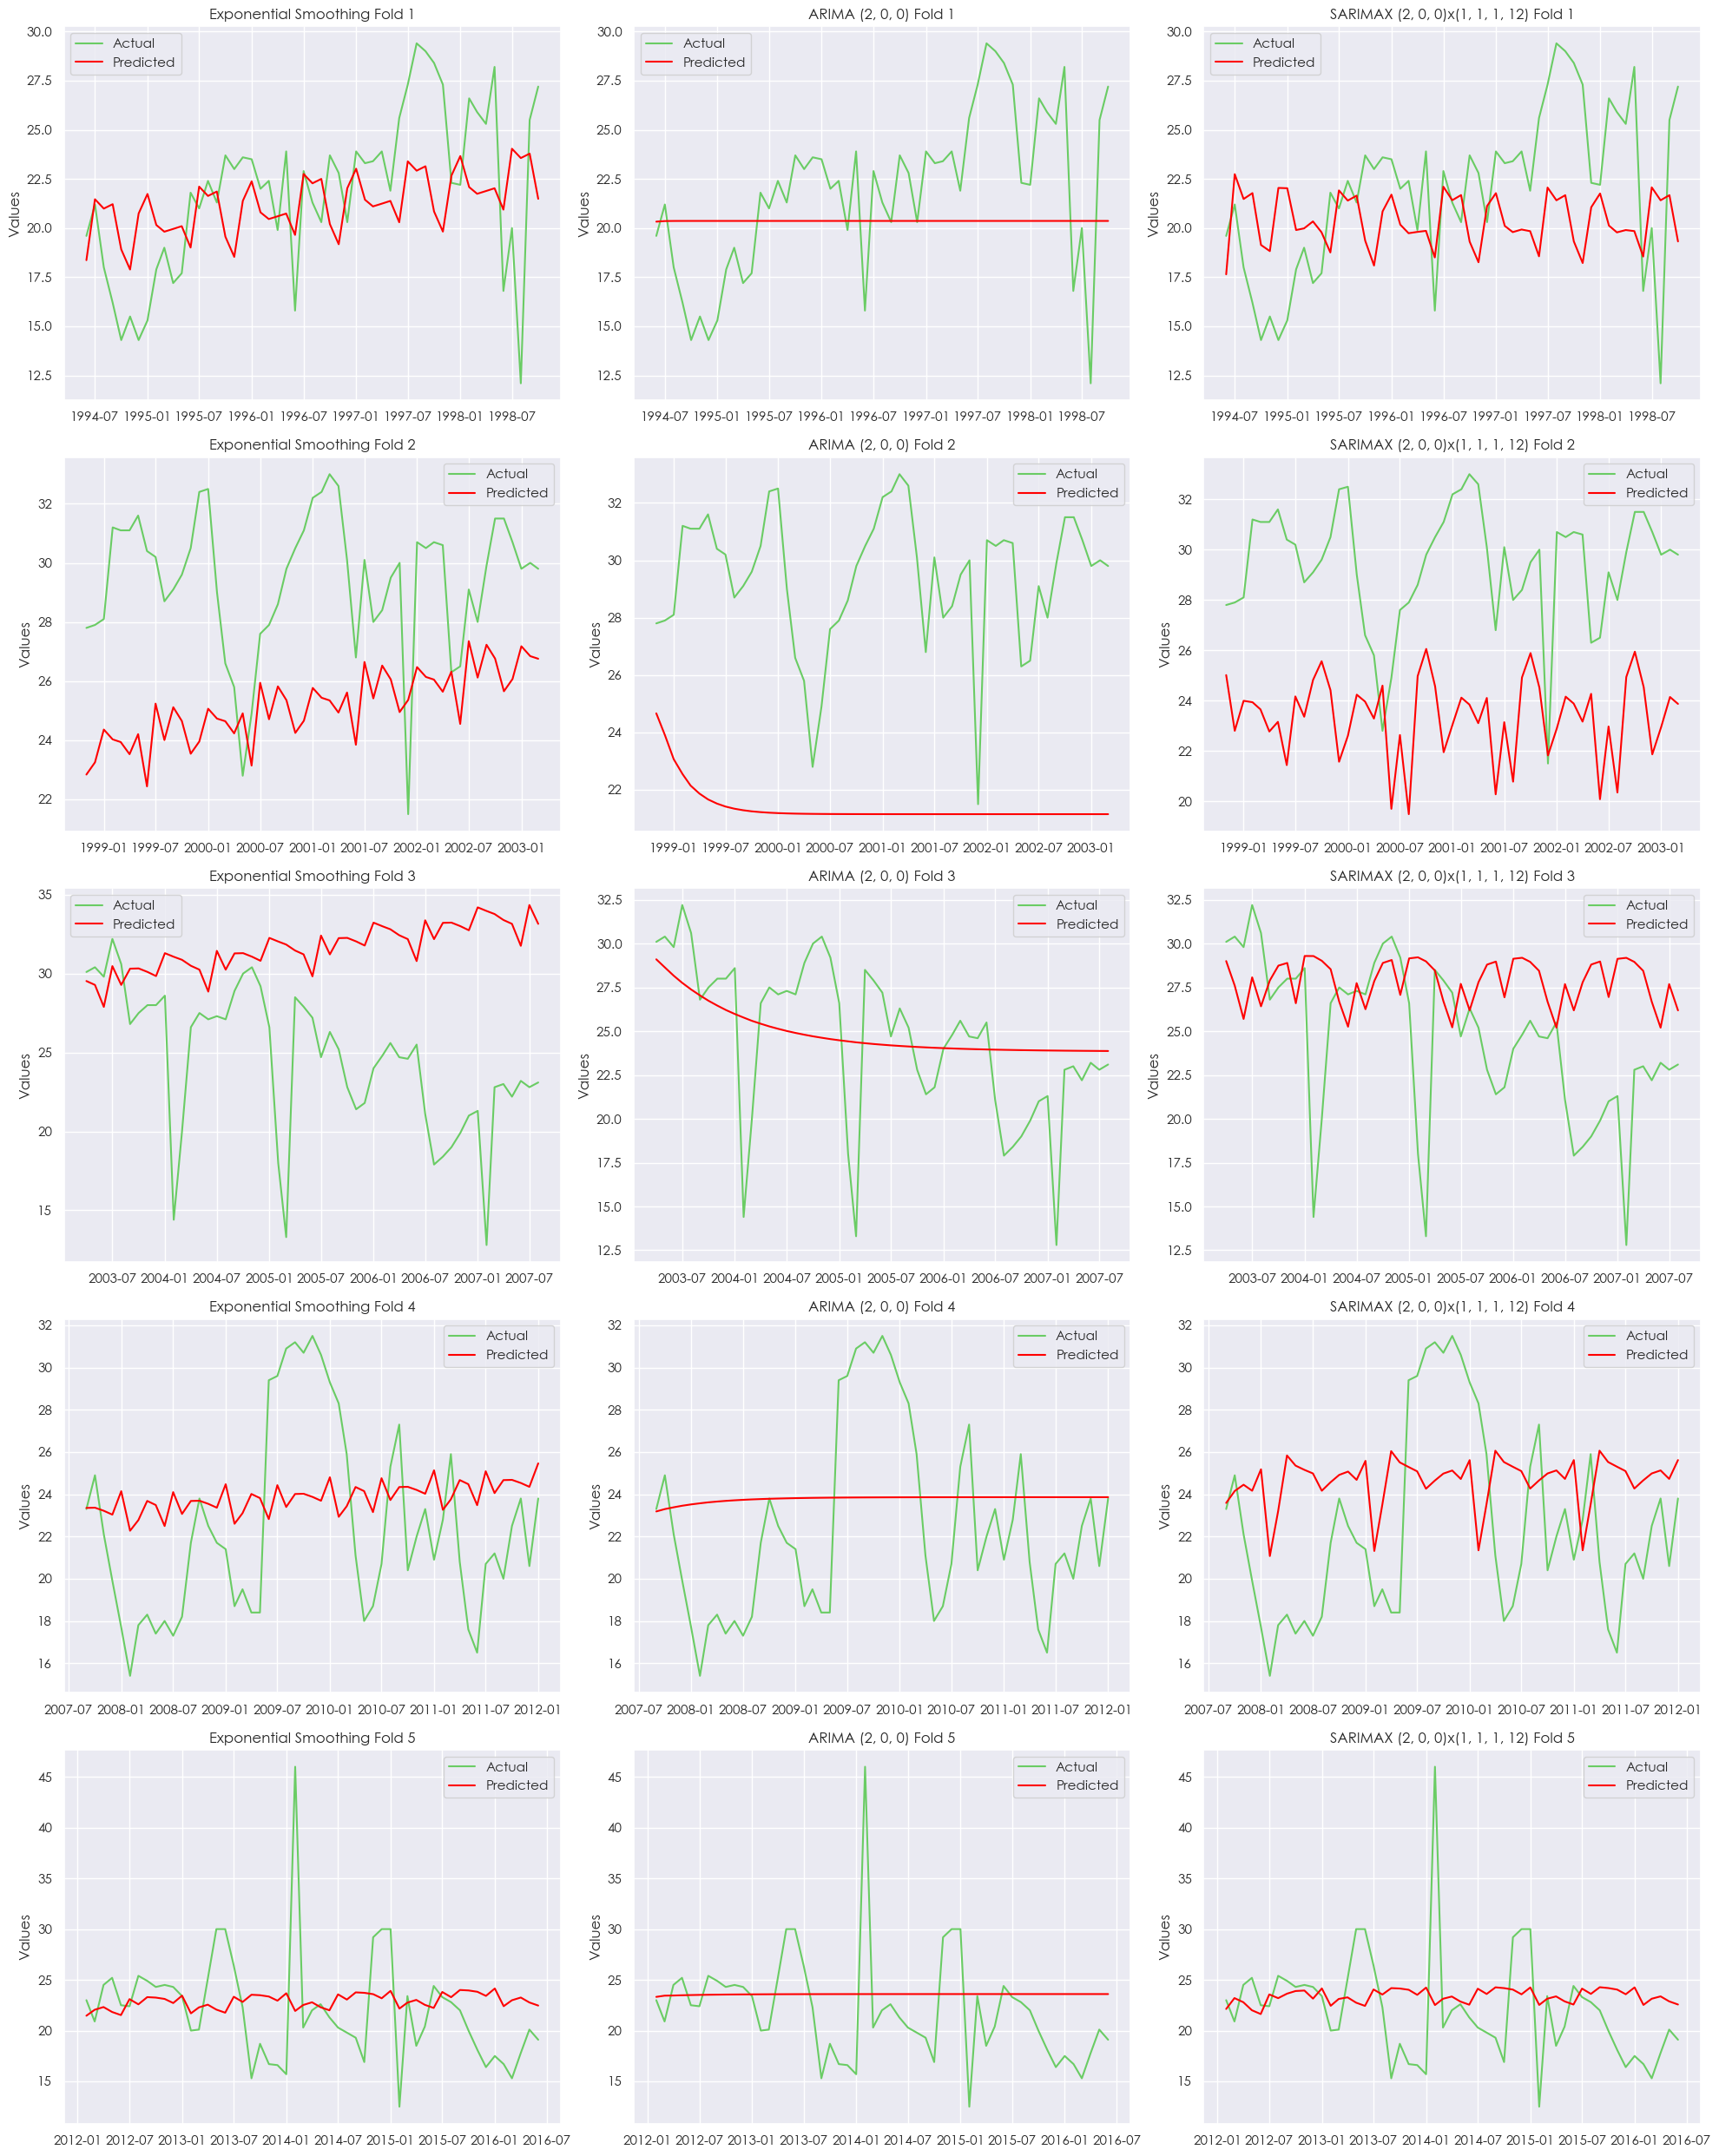

--------------------------Evaluation Metrics For Each Time Series Model--------------------------


MAE      MAPE        MSE      RMSE  \
Exponential Smoothing            4.598615  0.209034  34.185266  5.573778   
ARIMA (2, 0, 0)                  4.506664  0.193158  30.904016  5.325352   
SARIMAX (2, 0, 0)x(1, 1, 1, 12)  4.576113  0.204355  30.950077  5.522535   

                                 R-SQUARED  EXPLAINED VARIANCE  
Exponential Smoothing            -1.307016           -0.125389  
ARIMA (2, 0, 0)                  -2.377249            0.024226  
SARIMAX (2, 0, 0)x(1, 1, 1, 12)  -1.650866           -0.127646

In [31]:
# Perform Time series cross-validation for Gas Consumption
result = TimeSeriesCV(data=gas_train_,
                      arimaOrder=arimaOrder,
                      sarimaxOrder=sarimaxOrder,
                      sarimaxSeasonalOrder=sarimaxSeasonalOrder,
                      color=color[0])
# Print header for evaluation metrics
print("-"*26 + "Evaluation Metrics For Each Time Series Model" + "-"*26)
# Print evaluation metrics DataFrame
result

<span style='color:#6acc64'>**ANALYSIS OF EVALUATION METRICS AND PREDICTION LINEPLOTS:**</span>

From the evaluation metrics, we can see that ARIMA performs the best with the lowest MAPE of around 0.19, however, in terms of interpretability seen from the 5-folds, we can see that it only predicts a horizontal line and does not include seasonality. Hence we would not want to utilise ARIMA in our time series forecasting. Thus, the next best model would be SARIMAX with a MAPE of 0.204, and visually we can see it also does include seasonality in its predictions. Thus, we will utilize SARIMAX as the final time series model for time series forecasting of gas consumption.

**FINAL TIME SERIES MODEL FOR <span style='color:#6acc64'> GAS CONSUMPTION (TONS)</span>: SARIMAX**

### **MODEL SELECTION <span style='color:#d7c077'>[ELECTRICITY CONSUMPTION (TONS)]**

<p style='font-size:20px; color:#d7c077'> <b>MODEL PREPARATION</b> </p>

For the model preparation of ARIMA and SARIMAX for electricity consumption, hyperparameter tuning has to be performed for order and seasonal_order (for SARIMAX) as the ACF and PACF plots were inconclusive for us to determine the hyperparameters.

One thing to take note here is that the d_params should be set to at least 1 as we know that from the ADF test, the non-stationary data had to be differenced at least once.

**AUTOCORRELATION AND PARTIAL AUTOCORRELATION PLOT**

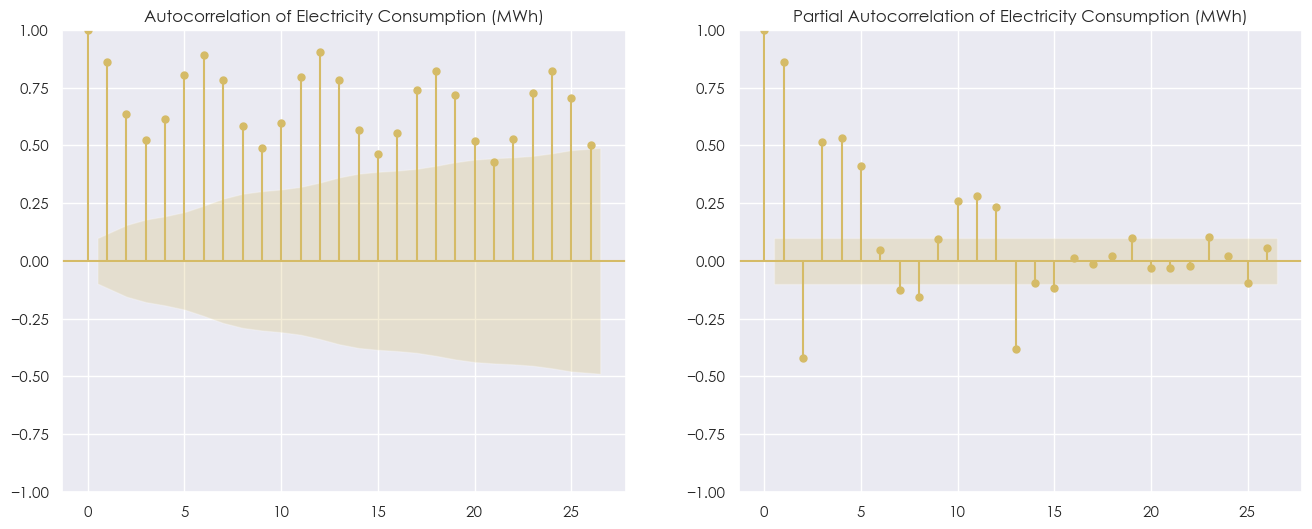

In [32]:
acf_pacf_plot(energy['Electricity Consumption (MWh)'],'Electricity Consumption (MWh)',color[1])

**SEASONAL AUTOCORRELATION PLOT**

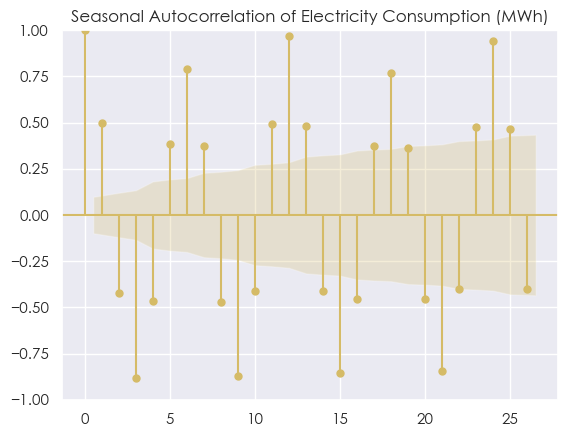

In [33]:
seasonal_acf_plot(energy,'Electricity Consumption (MWh)',color[1])

<p style='font-size:20px; color:#d7c077'> <b>ANALYSIS OF SACF, ACF & PACF PLOT FOR ELECTRICITY CONSUMPTION (MWH):</b></p>

From the SACF plot, we can see a yearly trend in autocorrelation where it fluctuates up and down every 3 months in a year, but cycles yearly at every 12th lag, hence there is a yearly seasonality trend, thus m in seasonal_order would be 12.

From the ACF and PACF plot, we can see that there are negative and positive autocorrelations with fluctuations which is inconclusive for us to determine the appropriate time series model and order to utilise.

Thus, we would likely need to perform GridSearch/Hyperparameter Tuning in order to determine the rest of the order and seasonal_order hyperparameter, and more testing to determine the model to use.

**SEASONAL_ORDER:** ( , , , 12)

<span style='color:#d7c077;'>**ARIMA**

<span style='color:#d7c077;'>**HYPERPARAMETER TUNING**

The progress bar from the tqdm library will show the estimate of how long the tuning would take.

<span style='color:#ee6666'><b>!</b> IF THE PROGRESS BAR IS NOT WORKING, STOP AND RUN THE CODE AGAIN <b>!</b></span>

In [34]:
import itertools
from tqdm.notebook import tqdm
# Ignore warnings (incase earlier ones did not work)
warnings.filterwarnings(action='ignore')
# Parameter grid/ Variables for hyperparameters to be tested
p_params = range(0,7)
d_params = range(1,3)
q_params = range(0,6)
# Dictionary for results
results = {}
# Train and test variable
train_data = electricity_train
val_data = electricity_val # Validation data is used
# Itertools to get all combinations of hyperparameters
hyperparameter_combi = itertools.product(p_params, d_params, q_params)
# Turn iterator into a list
list_hyperparameter_combi = list(hyperparameter_combi)
# Iterate over list of hyperparameter combinations with tqdm for progress BAR [total => total number of iterations to be completed]
for params in tqdm(list_hyperparameter_combi, desc="Processing", total=len(list_hyperparameter_combi)):
    try:
        p, d, q = params
        order = (p,d,q)
        label = str(order)
        model = ARIMA(endog=train_data,order=order,freq='MS').fit()
        pred = model.predict(start=min(val_data.index),end=max(val_data.index))
        score = metrics.mean_absolute_percentage_error(val_data, pred)
        results[label] = round(score,5)
    except: 
        continue
# Convert dictionary of results into DataFrame

results = pd.DataFrame.from_dict(results,orient='index',columns=['MAPE'])
# Get lowest MAPE score's index
best_index = results['MAPE'].idxmin()
# Print best results
header = "-"*10+ "Hyperparameter Tuning Results" + "-"*10
print(header + "\nBest hyperparameter: " + best_index + "\nBest MAPE score: " + str(results.loc[best_index,:]['MAPE']) + "\n" + "-"*len(header))

Processing:   0%|          | 0/84 [00:00<?, ?it/s]

----------Hyperparameter Tuning Results----------
Best hyperparameter: (3, 1, 3)
Best MAPE score: 0.02638
-------------------------------------------------


In [35]:
# Store variables needed
arimaOrder = tuple(map(int, best_index[1:-1].split(',')))

<span style='color:#d7c077;'>**SARIMAX**

<span style='color:#d7c077;'>**HYPERPARAMETER TUNING**

In [36]:
# Ignore warnings
warnings.filterwarnings(action='ignore')
# Parameter grid/ Variables for hyperparameters to be tested
p_params = range(0,4)
d_params = [1]
q_params = range(0,4)
P_params = range(0,3)
D_params = [1]
Q_params = range(0,3)
m_param = [12]
# Dictionary for results
results = {}
# Train and validation data variable
train_data = electricity_train
val_data = electricity_val # Validation data is used
# Itertools to get all combinations of hyperparameters
hyperparameter_combi = itertools.product(p_params, d_params, q_params,P_params, D_params, Q_params, m_param)
# Turn iterator into a list
list_hyperparameter_combi = list(hyperparameter_combi)
# Iterate over list of hyperparameter combinations with tqdm for progress BAR [total => total number of iterations to be completed]
for params in tqdm(list_hyperparameter_combi, desc="Processing", total=len(list_hyperparameter_combi)):
    try:
        p, d, q, P, D, Q, m = params
        order = (p,d,q)
        seasonal_order = (P,D,Q,m)
        label = str(order) + "x" + str(seasonal_order)
        score = sarimax_result(train=train_data,
                        val=val_data,
                        order=order,
                        seasonal_order=seasonal_order,
                        startPred=min(val_data.index),
                        endPred=max(val_data.index))
        results[label] = round(score,3)
    except: 
        continue
# Convert dictionary of results into DataFrame

results = pd.DataFrame.from_dict(results,orient='index',columns=['MAPE'])
# Get lowest MAPE score's index
best_index = results['MAPE'].idxmin()
# Print best results
header = "-"*10+ "Hyperparameter Tuning Results" + "-"*10
print(header + "\nBest hyperparameter: " + best_index + "\nBest MAPE score: " + str(results.loc[best_index,:]['MAPE']) + "\n" + "-"*len(header))
# Obtain tupes of order and seasonal_order
sarimax_order_string = best_index.split('x')
# Store for final forecast
electricity_params = best_index

Processing:   0%|          | 0/144 [00:00<?, ?it/s]

----------Hyperparameter Tuning Results----------
Best hyperparameter: (0, 1, 0)x(2, 1, 0, 12)
Best MAPE score: 0.027
-------------------------------------------------


In [37]:
# Store variables needed
sarimaxOrder = tuple(map(int, sarimax_order_string[0][1:-1].split(',')))
sarimaxSeasonalOrder = tuple(map(int, sarimax_order_string[1][1:-1].split(',')))

<p style='font-size:20px;'> <b>MODEL EVALUATION <span style='color:#d7c077;'>[ELECTRICITY CONSUMPTION (MWH)] </b>

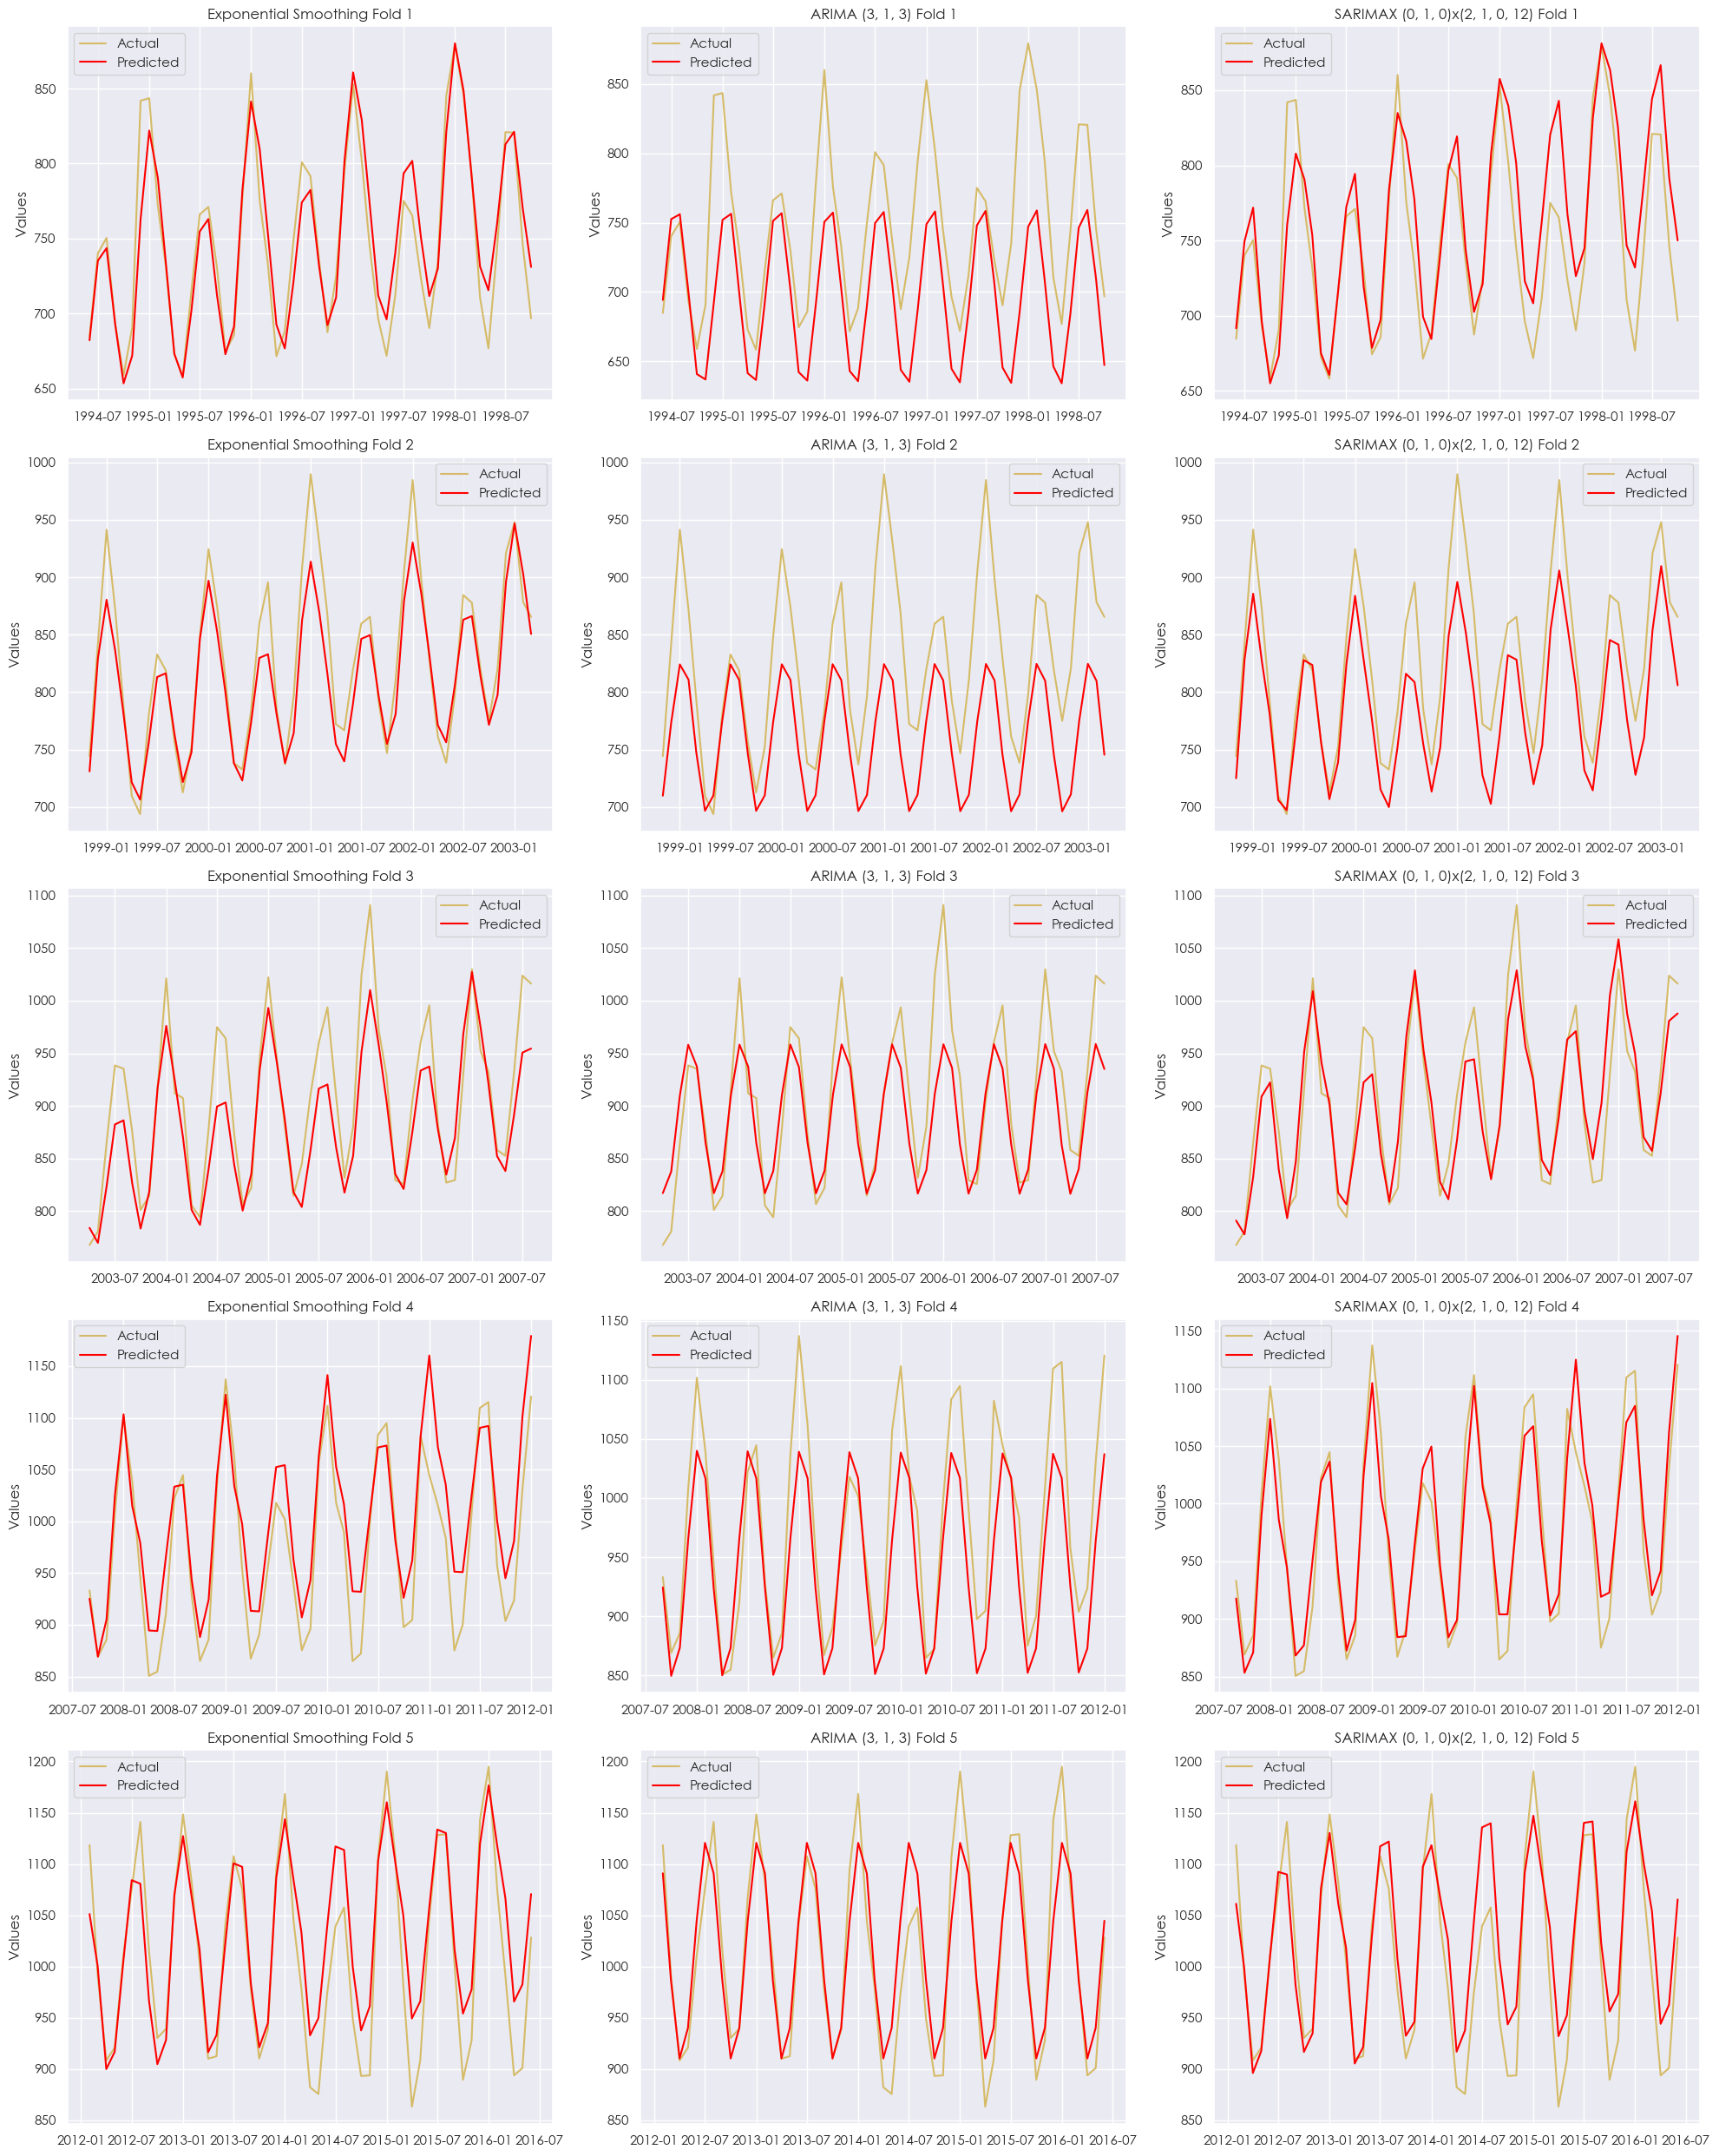

----------------------------Evaluation Metrics For Each Time Series Model----------------------------


MAE      MAPE          MSE       RMSE  \
Exponential Smoothing            26.474516  0.029079  1198.631021  33.630698   
ARIMA (3, 1, 3)                  43.178656  0.048727  3117.795597  53.744916   
SARIMAX (0, 1, 0)x(2, 1, 0, 12)  28.213453  0.031745  1233.847990  34.520726   

                                 R-SQUARED  EXPLAINED VARIANCE  
Exponential Smoothing             0.811330            0.867932  
ARIMA (3, 1, 3)                   0.377228            0.727915  
SARIMAX (0, 1, 0)x(2, 1, 0, 12)   0.780759            0.857095

In [38]:
# Perform Time series cross-validation for Gas Consumption
result = TimeSeriesCV(data=electricity_train_,
                      arimaOrder=arimaOrder,
                      sarimaxOrder=sarimaxOrder,
                      sarimaxSeasonalOrder=sarimaxSeasonalOrder,
                      color=color[1])
# Print header for evaluation metrics
print("-"*28 + "Evaluation Metrics For Each Time Series Model" + "-"*28)
# Print evaluation metrics DataFrame
result

<span style='color:#d7c077'>**ANALYSIS OF EVALUATION METRICS AND PREDICTION LINEPLOTS:**</span>

From this, we can see that the models performed performed well on the non-stationary data with the differenced order in the order and seasonal_order hyperparameter set to at least one, and hence there is no need to utilize the differenced/stationary data from earlier.

Comparing the three time series models used, we can see that Exponential Smoothing performed the best with the lowest MAPE score of 0.0291, and visually performed the best across all three models for all 5 folds. Thus, we will utilize Exponential Smoothing as the final time series model for time series forecasting of electricity consumption.


**FINAL TIME SERIES MODEL FOR <span style='color:#d7c077'> ELECTRICITY CONSUMPTION (MWH)</span>: HOLT-WINTERS EXPONENTIAL SMOOTHING**

### **MODEL SELECTION <span style='color:#4878d0'>[WATER CONSUMPTION (TONS)]**

<span style='font-size:20px; color: #4878d0;'>**MODEL PREPARATION**

**AUTOCORRELATION AND PARTIAL AUTOCORRELATION PLOT**

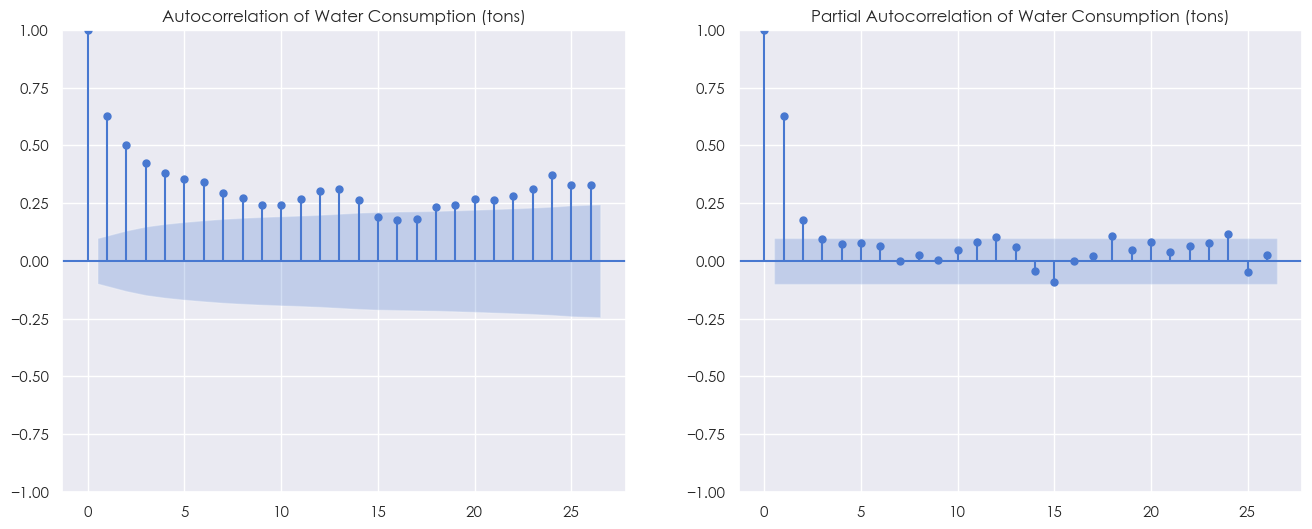

In [39]:
acf_pacf_plot(energy['Water Consumption (tons)'],'Water Consumption (tons)',color[2])

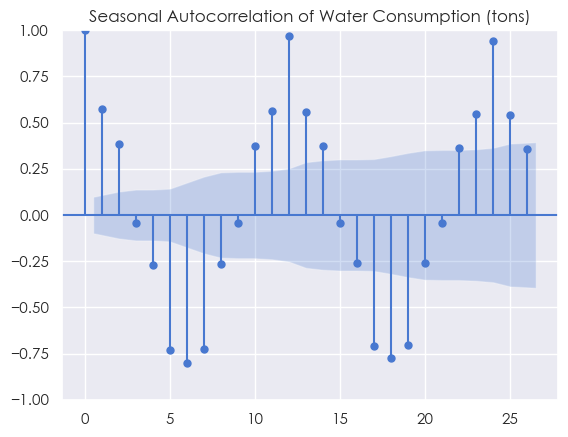

In [40]:
seasonal_acf_plot(energy,'Water Consumption (tons)',color[2])

<span style='font-size:20px; color: #4878d0;'>**ANALYSIS OF SACF, ACF & PACF PLOT FOR WATER CONSUMPTION (TONS):**

From the ACF Plot, we can observe a gradual decay in autocorrelation as well, showing a tail off, hence the series displays an AR signature. 

From the PACF Plot, we can observe that there are significant spikes in autocorrelation at lag 1 and lag 2, meaning that all the higher-order autocorrelations are effectively explained by the lag-2 autocorrelation as well. Hence, similar to gas consumption, an AR(2) model should be used.


**ARIMA order (p,d,q) for water consumption**:

Autoregressive order (p) -> 2 | Explanation: Since the PACF plot showed that the last significant lag spike occured at lag-2, p=2.

Differencing order (d) -> 0 | Explanation: The data is stationary, hence no differencing was required, thus number of differences required is 0.

Moving Average order (q) -> 0 | Explanation: Since the ACF plot showed a gradual decay, q=0.

**ORDER:** (2,0,0)

From the seasonal autocorrelation (SACF) plot, we can see that there is a spike in autocorrelation at every 12th lag, confirming that there is a yearly seasonality trend, hence m = 12.

**SARIMAX seasonal order (P,D,Q,m) for gas consumption**:


**SEASONAL_ORDER:** ( , , , 12)

<span style='color:#4878d0;'>**ARIMA**

ARIMA order was determined earlier to be (2,0,0), and frequency of time series data was identified to be the start of every month, thus freq='MS'.

In [41]:
# Variables needed
arimaOrder = (2,0,0)

<span style='color:#4878d0;'>**SARIMAX**

In [42]:
# Variables needed
sarimaxOrder = (2,0,0)
sarimaxSeasonalOrder = (1,1,1,12)


<p style='font-size:20px;'> <b>MODEL EVALUATION <span style='color:#4878d0;'>[WATER CONSUMPTION (TONS)]

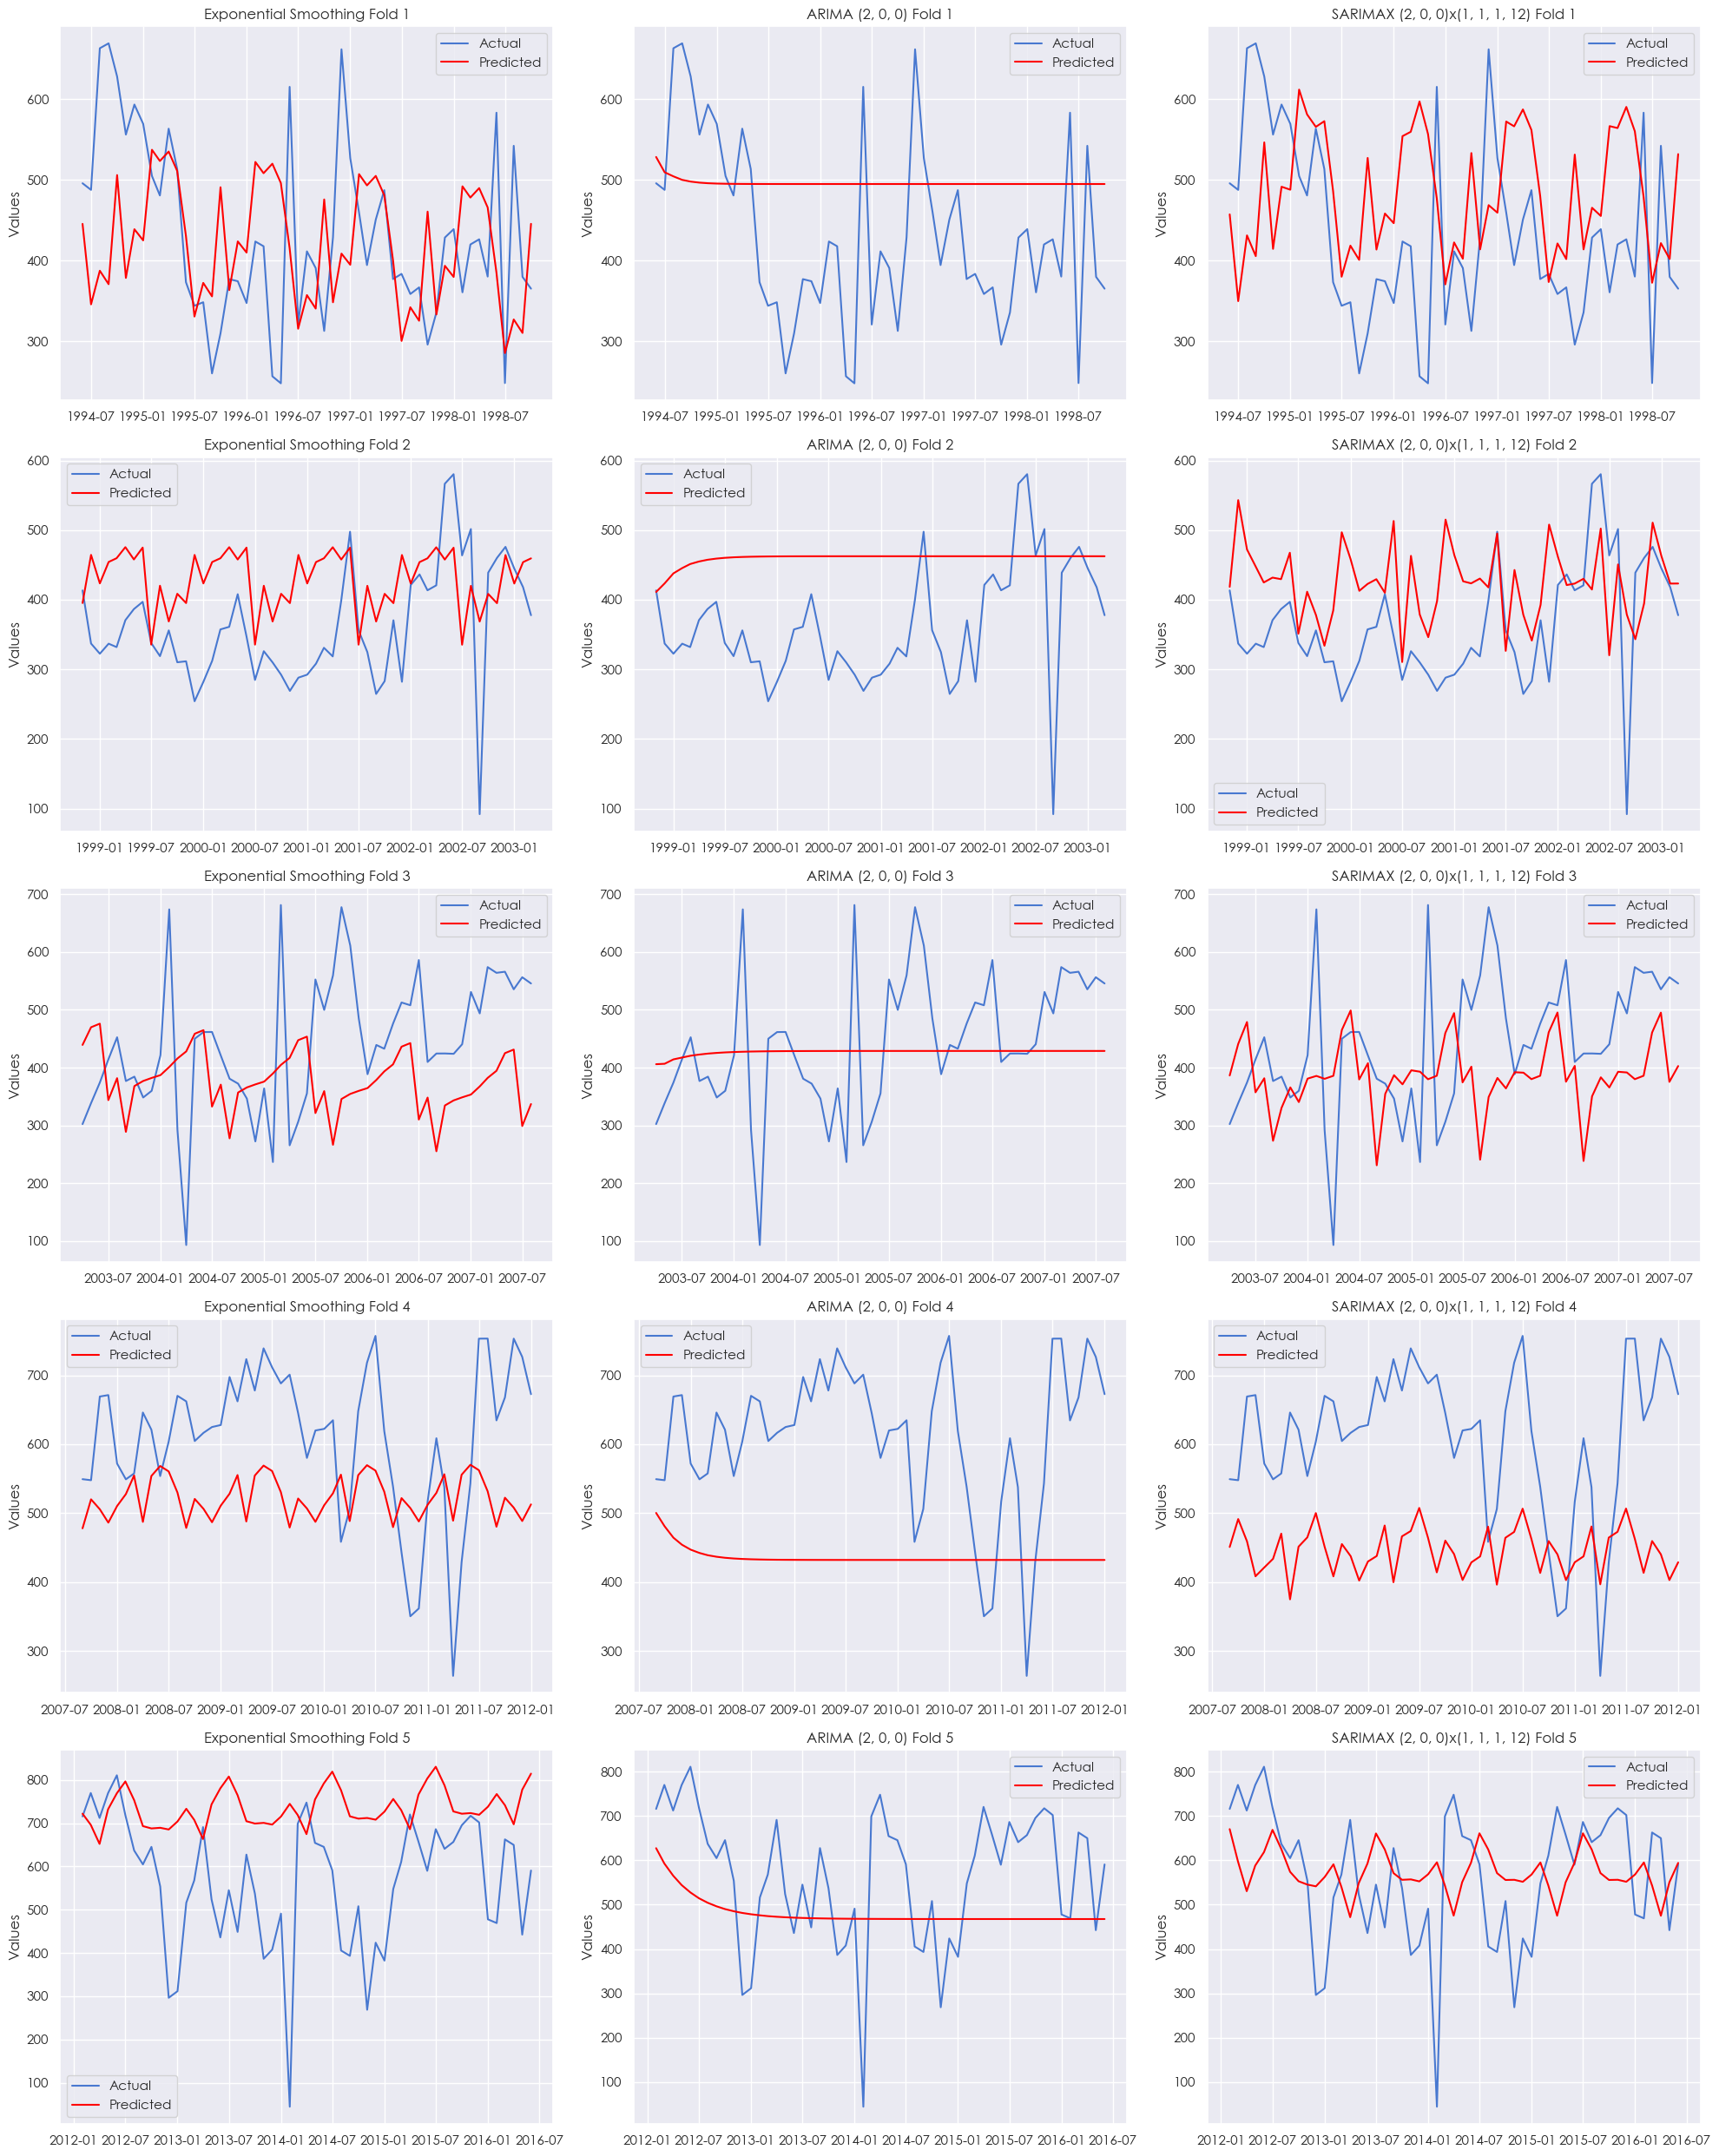

-----------------------------Evaluation Metrics For Each Time Series Model-----------------------------


MAE      MAPE           MSE  \
Exponential Smoothing            122.807705  0.348084  24245.475430   
ARIMA (2, 0, 0)                  126.776552  0.330223  22848.072970   
SARIMAX (2, 0, 0)x(1, 1, 1, 12)  122.735760  0.326488  22698.386413   

                                       RMSE  R-SQUARED  EXPLAINED VARIANCE  
Exponential Smoothing            149.842386  -0.732408           -0.145441  
ARIMA (2, 0, 0)                  147.625420  -0.924269            0.023338  
SARIMAX (2, 0, 0)x(1, 1, 1, 12)  148.107655  -0.856584           -0.177377

In [43]:
# Perform Time series cross-validation for Gas Consumption
result = TimeSeriesCV(data=water_train_,
                      arimaOrder=arimaOrder,
                      sarimaxOrder=sarimaxOrder,
                      sarimaxSeasonalOrder=sarimaxSeasonalOrder,
                      color=color[2])
# Print header for evaluation metrics
print("-"*29 + "Evaluation Metrics For Each Time Series Model" + "-"*29)
# Print evaluation metrics DataFrame
result

<span style='color:#4878d0'>**ANALYSIS OF EVALUATION METRICS AND PREDICTION LINEPLOTS:**</span>

Comparing the three time series models used, we can see that ARIMA and SARIMAX perform the best in terms of MAPE score at around 0.33, however, visually, we can see that ARIMA only predicts the mean value and predicted a horizontal line. Hence, the next best time series model would be SARIMAX, with a MAPE of 0.3326, and visually we can see that the model predicts with seasonality, even though it may seem rather inaccurate, it still performs better compared to Holt-Winters Exponential Smoothing model, and can be further improved with hyperparameter tuning. Thus, we will utilize SARIMAX as the final time series model for time series forecasting of water consumption.

**FINAL TIME SERIES MODEL FOR <span style='color:#4878d0'> WATER CONSUMPTION (TONS)</span>: SARIMAX**

### **CONCLUSION OF MODEL SELECTION FOR EACH FEATURE**

In conclusion, these are the final time series models selected for each energy consumption:

<span style='color:#6acc64'> <b> GAS CONSUMPTION (TONS): </b> </span> SARIMAX

<span style='color:#d7c077'> <b> ELECTRICITY CONSUMPTION (MWH): </b> </span> Holt-Winters Exponential Smoothing

<span style='color:#4878d0'> <b> WATER CONSUMPTION (TONS):</b> </span> SARIMAX

Before performing time series forecasting, we will perform hyperparameter tuning to improve the model in order to allow us to achieve more accurate results during forecasting.

## **5. HYPERPARAMETER TUNING**

Hyperparameter tuning would be conducted with train and validation data to ensure that test data would not be utilized until our final model. The validation set created earlier was used to hyperparameter tuning in order to prevent data leakage when using test set to tune.

For SARIMAX models, these are the hyperparameters to be tuned, where order = (p,d,q), and seasonal_order = (P,D,Q,m):
- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.
- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.

For Holt-Winters Exponential Smoothing, these are the hyperparameters to be tuned:
- trend: Type of trend component
- damped_trend: Should the trend component be damped
- seasonal: Type of seasonal component
- seasonal_periods: The number of periods in a complete seasonal cycle, set to 12 as there is yearly seasonal trend
- freq: The frequency of the time-series, set to 'MS' as data is the start of every month
- use_boxcox: Whether the Box-Cox transform be applied to the data first

The progress bar from the tqdm library will show the estimate of how long the tuning would take.

<span style='color:#ee6666'><b>!</b> IF THE PROGRESS BAR IS NOT WORKING, STOP AND RUN THE CODE AGAIN <b>!</b></span>

**FUNCTIONS FOR HYPERPARAMETER TUNING**

In [44]:
# Prediction lineplot function
def predPlot(train,test,predicted,datasetName,modelName):
    fig,ax = plt.subplots(figsize=(10,6))
    # Plot train line
    sns.lineplot(data=train,color='blue',ax=ax,label='Train',legend='brief')
    # Plot test line
    sns.lineplot(data=test,color='green',ax=ax,label='Test',legend='brief') 
    # Plot predicted line
    sns.lineplot(data=predicted,color='red',ax=ax,label='Predicted',legend='brief') 
    fig.suptitle(t='Lineplot of Prediction of ' + datasetName + " with " + modelName,y=0.92)

def tuneHyperparameterSARIMAX(train,val,p_params, d_params, q_params,P_params, D_params, Q_params, m_param,datasetName):
    # Dictionary for results
    results={}
    # Itertools to get all combinations of hyperparameters
    hyperparameter_combi = itertools.product(p_params, d_params, q_params,P_params, D_params, Q_params, m_param)
    # Turn iterator into a list
    list_hyperparameter_combi = list(hyperparameter_combi)
    # Iterate over list of hyperparameter combinations with tqdm for progress BAR [total => total number of iterations to be completed]
    for params in tqdm(list_hyperparameter_combi, desc="Processing", total=len(list_hyperparameter_combi)):
        p, d, q, P, D, Q, m = params
        order = (p,d,q)
        seasonal_order = (P,D,Q,m)
        label = str(order) + "x" + str(seasonal_order)
        score = sarimax_result(train=train,
                        val=val,
                        order=order,
                        seasonal_order=seasonal_order,
                        startPred=min(val.index),
                        endPred=max(val.index))
        results[label] = round(score,3)
    # Convert dictionary of results into DataFrame
    results = pd.DataFrame.from_dict(results,orient='index',columns=['MAPE'])
    # Get lowest MAPE score's index
    best_index = results['MAPE'].idxmin()
    # Print best results
    header = "-"*10+ datasetName + " Hyperparameter Tuning Results" + "-"*10
    print(header + "\nBest hyperparameter: " + best_index + "\nBest MAPE score: " + str(results.loc[best_index,:]['MAPE']) + "\n" + "-"*len(header))
    return best_index

### <span style='color:#6acc64'> <b> GAS CONSUMPTION </b> </span>

The best time series model identified for gas consumption was **SARIMAX**.

The parameter grid for d was set to [0] as we know the data is stationary already and does not need to be differenced.

The parameter grid for D was set to [1] as we know that the data has a clear seasonal trend, and should be removed before forecasting.

In [45]:
# Parameter grid/ Variables for hyperparameters to be tested
p_params = range(0,4)
d_params = [0]
q_params = range(0,4)
P_params = range(0,2)
D_params = [1]
Q_params = range(0,2) 
m_param = [12]
# Perform hyperparameter tuning 
gas_params = tuneHyperparameterSARIMAX( train=gas_train,
                                        val=gas_val,
                                        p_params=p_params,
                                        d_params=d_params, 
                                        q_params=q_params,
                                        P_params=P_params, 
                                        D_params=D_params, 
                                        Q_params=Q_params, 
                                        m_param=m_param,
                                        datasetName='Gas Consumption' )

Processing:   0%|          | 0/64 [00:00<?, ?it/s]

----------Gas Consumption Hyperparameter Tuning Results----------
Best hyperparameter: (2, 0, 1)x(1, 1, 1, 12)
Best MAPE score: 0.195
-----------------------------------------------------------------


### <span style='color:#d7c077'> **ELECTRICITY CONSUMPTION** </span>


The best time series model identified for electricity consumption was **Holt-Winters Exponential Smoothing**. 

In [46]:
# Train and validation set variables
train = electricity_train
test = electricity_val
# Parameter grid/ Variables for hyperparameters to be tested
dampened_params = [True,False]
seasonal_type = ['add','mul'] # Test multiplicative as we are not fully confident that there is an additive trend
trend_param = ['add','mul'] # Test multiplicative as we are not fully confident that there is an additive trend
seasonal_periods = [12]
freq=['MS']
boxcox_params = [True,False]
# Dictionary for results
results = {}
# Itertools to get all combinations of hyperparameters
hyperparameter_combi = itertools.product(dampened_params,seasonal_type,trend_param,seasonal_periods,freq,boxcox_params)
# Turn iterator into a list
list_hyperparameter_combi = list(hyperparameter_combi)
# Iterate over list of hyperparameter combinations with tqdm for progress bar
for params in tqdm(list_hyperparameter_combi, desc="Processing", total=len(list_hyperparameter_combi)):
    label= str(params)
    dampen, seasonal, trend, seasonal_periods, freq, boxcox = params
    expo = ExponentialSmoothing(
        train,
        trend=trend,
        damped_trend=dampen,
        seasonal=seasonal,
        seasonal_periods=seasonal_periods,
        freq=freq,
        use_boxcox=boxcox,
        missing='raise'
    ).fit()
    forecast = expo.forecast(steps=len(test))
    score = metrics.mean_absolute_percentage_error(forecast,test)
    results[label] = round(score,3)
# Convert dictionary of results into DataFrame
results = pd.DataFrame.from_dict(results,orient='index',columns=['MAPE'])
# Get lowest MAPE score's index
best_index = results['MAPE'].idxmin()
# Print best results
header = "-"*15 + "Electricity Consumption Hyperparameter Tuning Results" + "-"*15
print(header + "\nBest hyperparameter: " + best_index + "\nBest MAPE score: " + str(results.loc[best_index,:]['MAPE']) + "\n" + "-"*len(header))
# Store best hyperparameters
elect_params = best_index

Processing:   0%|          | 0/16 [00:00<?, ?it/s]

---------------Electricity Consumption Hyperparameter Tuning Results---------------
Best hyperparameter: (True, 'mul', 'mul', 12, 'MS', False)
Best MAPE score: 0.03
-----------------------------------------------------------------------------------


### <span style='color:#4878d0'> <b> WATER CONSUMPTION </b> </span>

The best time series model identified for water consumption was **SARIMAX**.

The parameter grid for d was also set to [0] as we know the data is stationary already and does not need to be differenced.

The parameter grid for D was also set to [1] as we know that the data has a clear seasonal trend, and should be removed before forecasting.

In [47]:
# Parameter grid/ Variables for hyperparameters to be tested
p_params = range(0,4)
d_params = [0]
q_params = range(0,4)
P_params = range(0,3)
D_params = [0,1]
Q_params = range(0,3)
m_param = [12]
# Perform hyperparameter tuning 
water_params = tuneHyperparameterSARIMAX(train=water_train,
                                        val=water_val,
                                        p_params=p_params,
                                        d_params=d_params, 
                                        q_params=q_params,
                                        P_params=P_params, 
                                        D_params=D_params, 
                                        Q_params=Q_params, 
                                        m_param=m_param,
                                        datasetName='Water Consumption' )

Processing:   0%|          | 0/288 [00:00<?, ?it/s]

----------Water Consumption Hyperparameter Tuning Results----------
Best hyperparameter: (1, 0, 2)x(2, 0, 0, 12)
Best MAPE score: 0.4
-------------------------------------------------------------------


## **6. TIME SERIES FORECASTING**

With our best time series models and hyperparameters identified for each column in the energy consumption dataset, we will now perform the final time series forecast, utilising the train and test sets to compare how well the final models perform by comparing the forecasted values with unseen test data.

**FUNCTION FOR TIME SERIES FORECASTING**

In [48]:
# Function to plot and print everything needed for final forecast
def finalPlot(order,seasonalorder,train,test,datasetName,modelName): # FOR SARIMAX ONLY!
    # Instantiate and fit model
    sarimax = SARIMAX(endog=train,order=order,seasonal_order=seasonalorder,freq='MS').fit()
    # Summary of SARIMAX model
    print(sarimax.summary())
    # Plot the Diagnostics plot for SARIMAX
    sarimax.plot_diagnostics(figsize=(12,8))
    plt.show()
    # Predict and plot lineplot
    forecast = sarimax.forecast(len(test))
    predPlot(train=train,test=test,predicted=forecast,datasetName=datasetName,modelName=modelName)
    return predResult(test=test,predicted=forecast,modelName=modelName)
    

### <span style='color:#6acc64'> <b> GAS CONSUMPTION (TONS)</b> </span>

                                     SARIMAX Results                                      
Dep. Variable:             Gas Consumption (tons)   No. Observations:                  318
Model:             SARIMAX(2, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -842.873
Date:                            Fri, 11 Aug 2023   AIC                           1697.747
Time:                                    23:37:08   BIC                           1720.088
Sample:                                01-01-1990   HQIC                          1706.682
                                     - 06-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.4090      0.056     24.975      0.000       1.298       1.520
ar.L2         -0.4148      0.050   

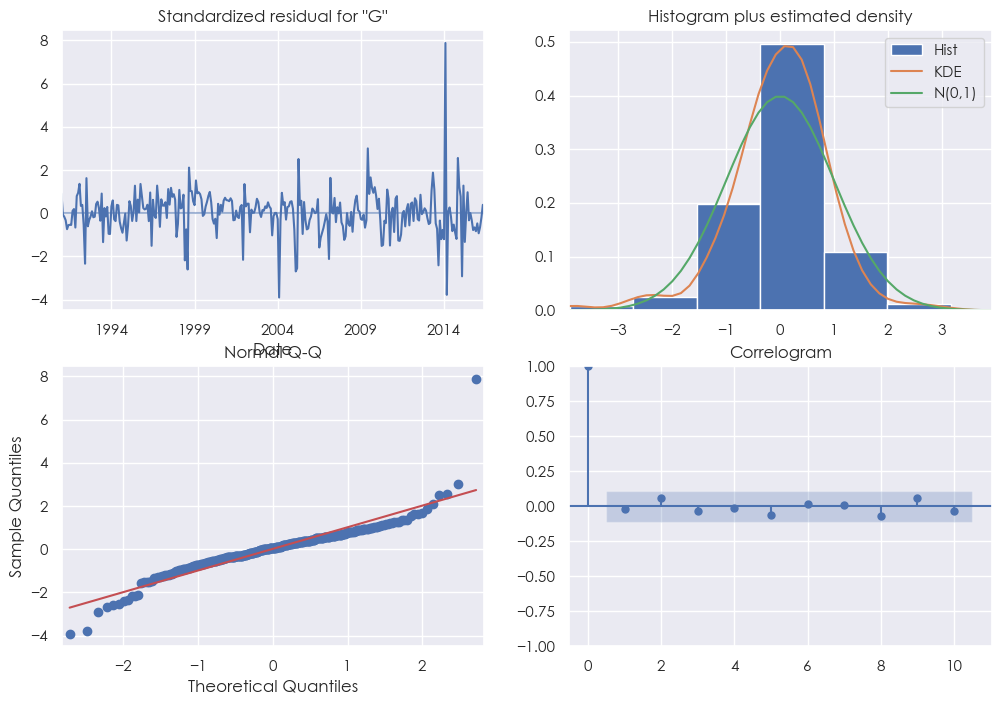

------------Evaluation Metrics for Gas Consumption on SARIMAX (2, 0, 1)x(1, 1, 1, 12)------------


MAE      MAPE       MSE      RMSE  \
SARIMAX (2, 0, 1)x(1, 1, 1, 12)  5.343541  0.207714  36.21188  6.017631   

                                 R-SQUARED  EXPLAINED VARIANCE  
SARIMAX (2, 0, 1)x(1, 1, 1, 12)  -0.885381            0.095605

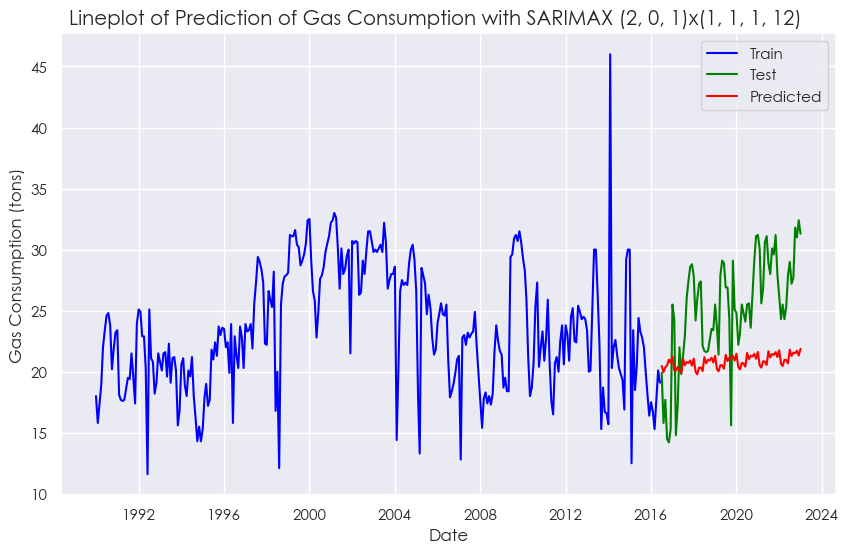

In [49]:
# Get best hyperparameters
gas_string = gas_params.split('x')
order = tuple(map(int, gas_string[0][1:-1].split(',')))
seasonalorder = tuple(map(int, gas_string[1][1:-1].split(',')))
# Variables
modelName = 'SARIMAX ' + str(order) + 'x' + str(seasonalorder)
datasetName = 'Gas Consumption'
# Plots and summary function
result = finalPlot(order=order,seasonalorder=seasonalorder,train=gas_train_,test=gas_test,datasetName=datasetName,modelName=modelName)
# Print evaluation metrics
print('-'*12 + 'Evaluation Metrics for ' + datasetName + " on " + modelName + '-' * 12)
result

<span style='color:#6acc64; font-size:24px;'>**ANALYSIS OF FINAL FORECAST FOR GAS CONSUMPTION:**

<span style='font-size:20px;'>**DIAGNOSTIC PLOT:**

**Standardized residual plot** -> there are no obvious patterns in the residuals

**Histogram plus KDE estimate plot** -> the KDE curve has a normal distribution 

**Normal Q-Q plot** -> most data points lie on the straight line

**Correlogram** -> all the lags greater than zero do not lie outside the confidence band

Thus, we can see that the SARIMAX time series model is a good fit for the data.

<span style='font-size:20px;'>**EVALUATION METRICS AND LINEPLOT:**

From the evaluation metrics, we can observe that the MAPE is rather high at 0.208, and from the lineplot, we can also observe that the prediction is not that accurate compared to the test data. This shows that the final model did not perform up to expectations even after hyperparameter tuning and selecting the best models. Hence, I would likely want to fine tune this model later on in hopes to improve it.

### <span style='color:#d7c077'> **ELECTRICITY CONSUMPTION (MWH)** </span>

In [50]:
print('Best hyperparameters for electricity consumption are: ' + elect_params)

Best hyperparameters for electricity consumption are: (True, 'mul', 'mul', 12, 'MS', False)


-------------Evaluation Metrics for Electricity Consumption on Exponential Smoothing-------------


MAE      MAPE          MSE       RMSE  R-SQUARED  \
Exponential Smoothing  25.810364  0.024665  1148.332278  33.887052   0.876034   

                       EXPLAINED VARIANCE  
Exponential Smoothing            0.876238

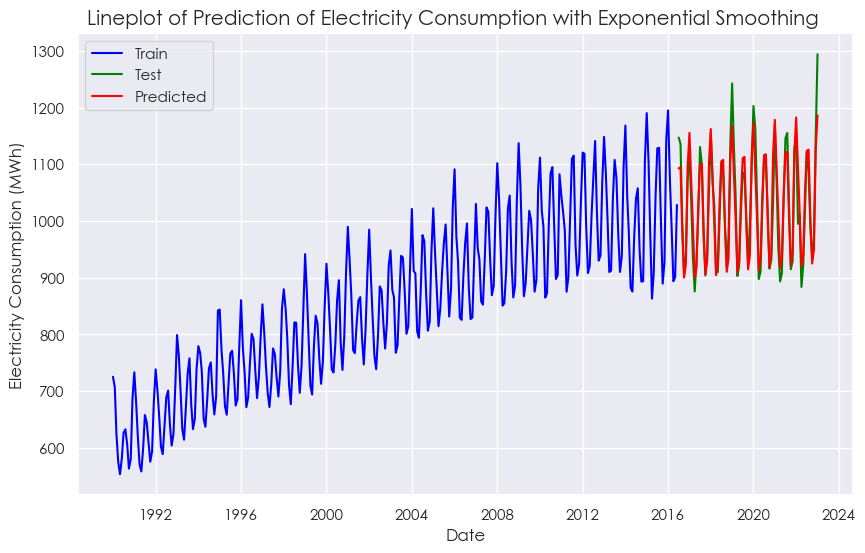

In [51]:
# Get variables that can be attained from the string
damp = False
trend = elect_params[1:-1].split(', ')[1][1:-1]
seasonal = elect_params[1:-1].split(', ')[2][1:-1]
seasonal_periods = int(elect_params[1:-1].split(', ')[3])
freq = elect_params[1:-1].split(', ')[4][1:-1]
boxcox = False
if (elect_params[1:-1].split(', ')[0] == 'True'):
    damp = True
if (elect_params[1:-1].split(', ')[5] == 'True'):
    boxcox = True
# Instantiate and fit final model
final_expo = ExponentialSmoothing(electricity_train_,
                                  damped_trend=damp,
                                  trend=trend,
                                  seasonal=seasonal,
                                  seasonal_periods=seasonal_periods,
                                  freq=freq,
                                  use_boxcox=boxcox,
                                  missing='raise').fit()
# Forecast values
forecast = final_expo.forecast(steps=len(electricity_test))
# Get DataFrame of evaluation metrics
result = predResult(electricity_test,forecast,'Exponential Smoothing')
# Prediction lineplot
predPlot(train=electricity_train_,test=electricity_test,predicted=forecast,datasetName='Electricity Consumption',modelName='Exponential Smoothing')
# Print evaluation metrics
print('-'*13 + 'Evaluation Metrics for Electricity Consumption on Exponential Smoothing' + '-' * 13)
result

<span style='color:#d7c077; font-size:24px;'>**ANALYSIS OF FINAL FORECAST FOR ELECTRICITY CONSUMPTION:**

<span style='font-size:20px;'>**EVALUATION METRICS AND LINEPLOT:**

From the evaluation metrics, we can observe that the MAPE for electricity consumption was very low, at 0.02, which shows us that the model performed very well in terms of forecasting when comparing forecasted values to test values, only making an error of around 2%. From the lineplot, we also can observe that the forecast matches the test data with minimal errors. Overall showing that Exponential Smoothing performed well in forecasting for Electricity Consumption.

### <span style='color:#4878d0'> <b> WATER CONSUMPTION (TONS)</b> </span>

                                      SARIMAX Results                                      
Dep. Variable:            Water Consumption (tons)   No. Observations:                  318
Model:             SARIMAX(1, 0, 2)x(2, 0, [], 12)   Log Likelihood               -1927.882
Date:                             Fri, 11 Aug 2023   AIC                           3867.763
Time:                                     23:37:11   BIC                           3890.336
Sample:                                 01-01-1990   HQIC                          3876.779
                                      - 06-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9985      0.004    278.824      0.000       0.991       1.006
ma.L1         -0.5504      

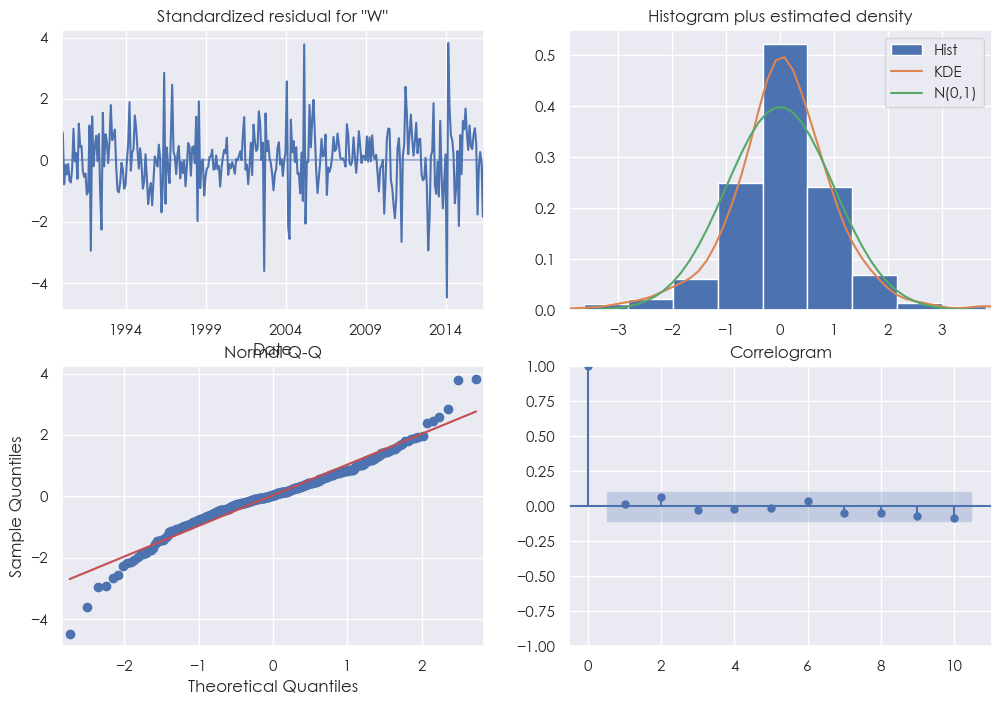

--------------Evaluation Metrics for Water Consumption on SARIMAX (1, 0, 2)x(2, 0, 0, 12)--------------


MAE      MAPE           MSE  \
SARIMAX (1, 0, 2)x(2, 0, 0, 12)  99.262932  0.252914  15532.817461   

                                       RMSE  R-SQUARED  EXPLAINED VARIANCE  
SARIMAX (1, 0, 2)x(2, 0, 0, 12)  124.630724  -0.477565           -0.048713

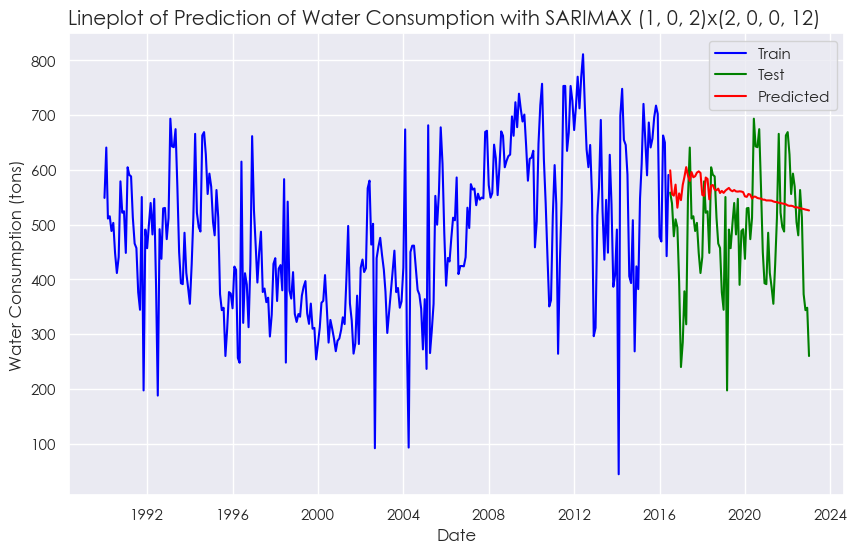

In [52]:
# Get best hyperparameters
water_string = water_params.split('x')
order = tuple(map(int, water_string[0][1:-1].split(',')))
seasonalorder = tuple(map(int, water_string[1][1:-1].split(',')))
# Variables
modelName = 'SARIMAX ' + str(order) + 'x' + str(seasonalorder)
datasetName = 'Water Consumption'
# Plots and summary function
result = finalPlot(order=order,seasonalorder=seasonalorder,train=water_train_,test=water_test,datasetName=datasetName,modelName=modelName)
# Print evaluation metrics
print('-'*14 + 'Evaluation Metrics for ' + datasetName + " on " + modelName + '-' * 14)
result

<span style='color:#4878d0; font-size:24px;'>**ANALYSIS OF FINAL FORECAST FOR WATER CONSUMPTION:**

<span style='font-size:20px;'>**DIAGNOSTIC PLOT:**

**Standardized residual plot** -> there are no obvious patterns in the residuals

**Histogram plus KDE estimate plot** -> the KDE curve has a normal distribution 

**Normal Q-Q plot** -> most data points lie on the straight line

**Correlogram** -> all the lags greater than zero do not lie outside the confidence band

Thus, we can see that the final SARIMAX time series model is a good fit for the data.

<span style='font-size:20px;'>**EVALUATION METRICS AND LINEPLOT:**

From the evaluation metrics, we can observe that the MAPE is rather high at 0.253, and from the lineplot, we can also observe that the prediction made by the model was somewhat linear and did not compare to the test data well. Similar to the final forecast for gas consumption, this shows that the final model did not perform up to expectations, and I would fine tune the model later on in hopes to improve the results as well.

### **FINE-TUNING MODELS**

From the final models, the MAPE scores for Gas and Water consumption still seemed rather high, and I was not satisfied with the results, hence I attempted to fine-tune models manually in order to try to improve their predictions. I tried to fine-tune the hyperparameters with values that were not tested during hyperparameter tuning as by including so many values, it would become too computationally expensive and take very long to run each hyperparameter tuning.

One thing to note here is that the test data that the forecasts made here were compared to may be overfitted and lead to overly optimistic results, and hence these fine-tuned models should be further tested on new unseen data if possible before actually being fully deployed to the real world. 

<span style='color:#6acc64; font-size:24px;'> <b> GAS CONSUMPTION (TONS)</b> </span>

                                     SARIMAX Results                                      
Dep. Variable:             Gas Consumption (tons)   No. Observations:                  318
Model:             SARIMAX(3, 0, 3)x(5, 1, 3, 12)   Log Likelihood                -840.458
Date:                            Fri, 11 Aug 2023   AIC                           1710.917
Time:                                    23:37:35   BIC                           1766.770
Sample:                                01-01-1990   HQIC                          1733.254
                                     - 06-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2557      0.099     -2.579      0.010      -0.450      -0.061
ar.L2          0.0903      0.072   

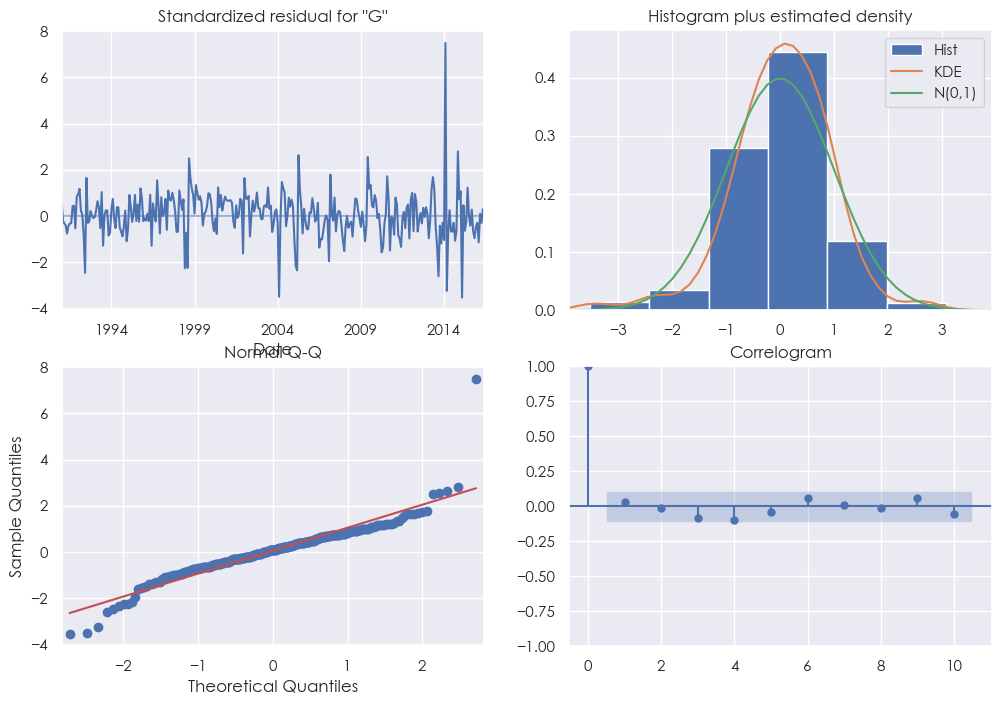

------------Evaluation Metrics for Gas Consumption on SARIMAX (3, 0, 3)x(5, 1, 3, 12)------------


MAE      MAPE        MSE      RMSE  \
SARIMAX (3, 0, 3)x(5, 1, 3, 12)  3.949226  0.161023  21.861773  4.675657   

                                 R-SQUARED  EXPLAINED VARIANCE  
SARIMAX (3, 0, 3)x(5, 1, 3, 12)  -0.138239            0.118211

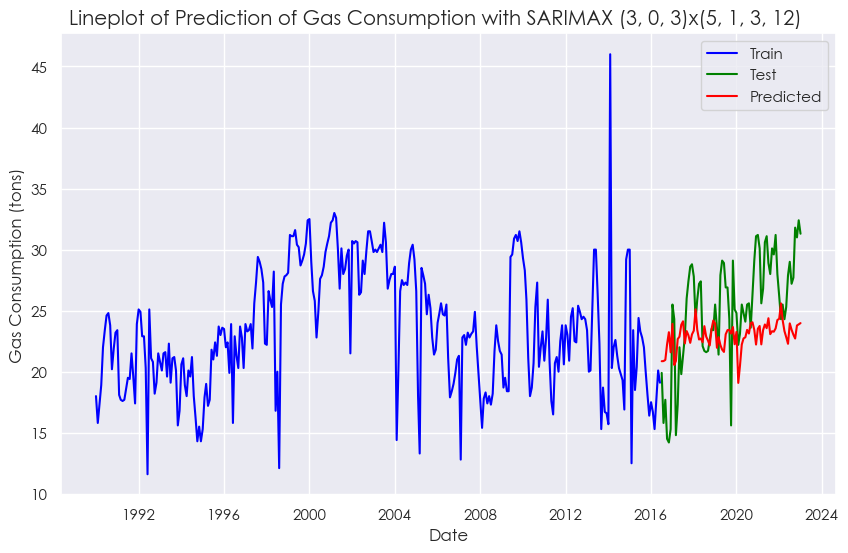

In [53]:
# Set fine tuned hyperparameters
order = (3,0,3)
seasonalorder = (5,1,3,12)
# Variables
modelName = 'SARIMAX ' + str(order) + 'x' + str(seasonalorder)
datasetName = 'Gas Consumption'
# Plots and summary function
result = finalPlot(order=order,seasonalorder=seasonalorder,train=gas_train_,test=gas_test,datasetName=datasetName,modelName=modelName)
# Print evaluation metrics
print('-'*12 + 'Evaluation Metrics for ' + datasetName + " on " + modelName + '-' * 12)
result

<span style='color:#6acc64'>**ANALYSIS OF FINE TUNING OF TIME SERIES MODEL FOR GAS CONSUMPTION:**

From adjusting the order and seasonal_order hyperparameter of the SARIMAX model to (3,0,3)x(5,1,3,12), we can see major improvements in the model's forecasting compared to actual test data visually from the lineplot, and from the MAPE score, where compared to the previous model, there was a decrease in MAPE score from around 0.20 to 0.16, and the lineplot shows a more accurate representation of the test data compared to what the final model had. Overall, this shows that manually fine tuning did help to improve the model's performance.

<span style='color:#4878d0; font-size:24px;'> <b> WATER CONSUMPTION (TONS)</b> </span>

                                           SARIMAX Results                                           
Dep. Variable:                      Water Consumption (tons)   No. Observations:                  318
Model:             SARIMAX(2, 0, 5)x(5, 1, [1, 2, 3, 4], 12)   Log Likelihood               -1866.269
Date:                                       Fri, 11 Aug 2023   AIC                           3766.538
Time:                                               23:38:00   BIC                           3829.839
Sample:                                           01-01-1990   HQIC                          3791.854
                                                - 06-01-2016                                         
Covariance Type:                                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4439     

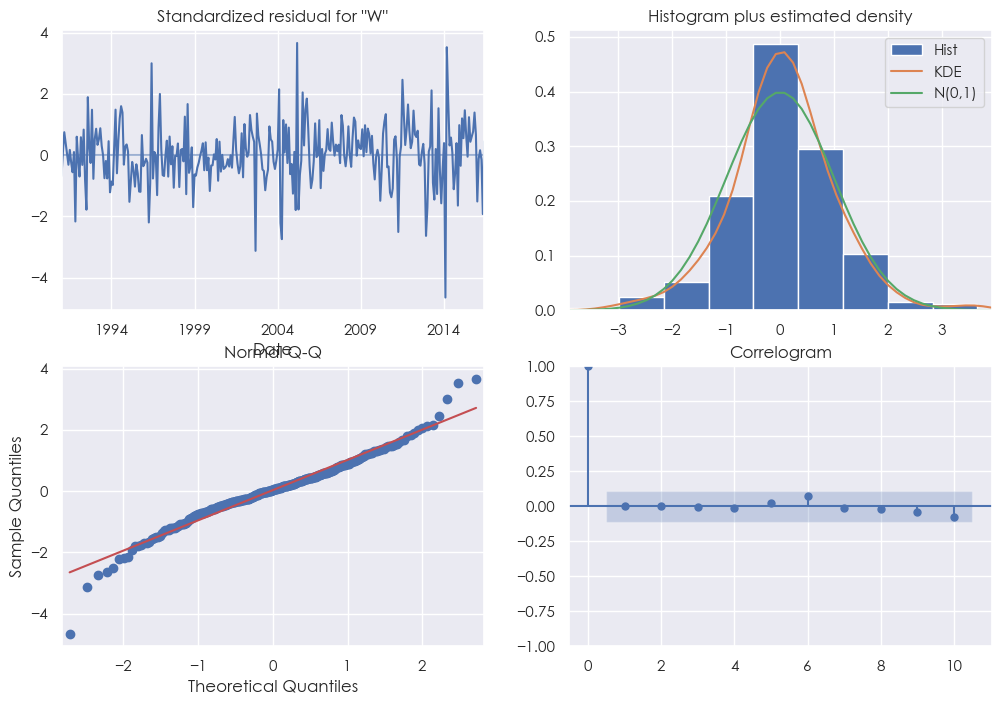

--------------Evaluation Metrics for Water Consumption on SARIMAX (2, 0, 5)x(5, 1, 4, 12)--------------


MAE      MAPE           MSE  \
SARIMAX (2, 0, 5)x(5, 1, 4, 12)  81.696328  0.200952  11348.578235   

                                       RMSE  R-SQUARED  EXPLAINED VARIANCE  
SARIMAX (2, 0, 5)x(5, 1, 4, 12)  106.529706  -0.079538           -0.021762

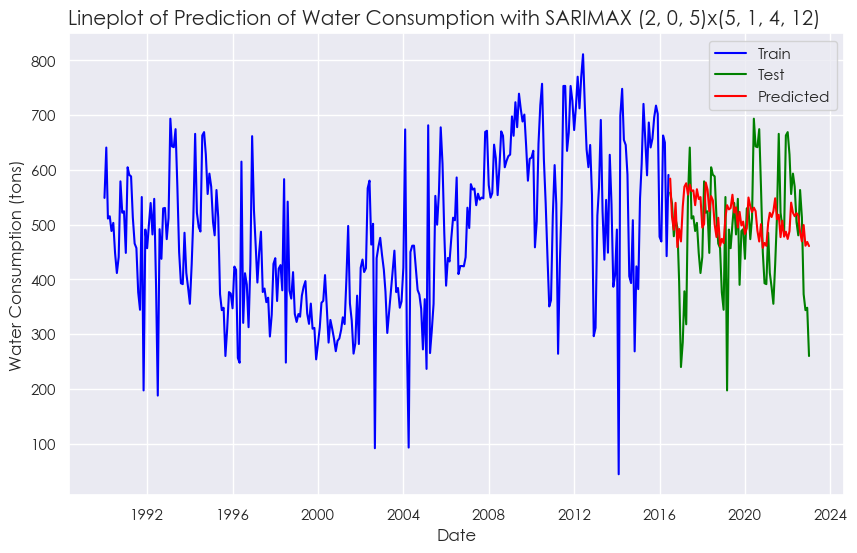

In [54]:
# Set fine tuned hyperparameters
order = (2,0,5)
seasonalorder = (5,1,4,12)
# Variables
modelName = 'SARIMAX ' + str(order) + 'x' + str(seasonalorder)
datasetName = 'Water Consumption'
# Plots and summary function
result = finalPlot(order=order,seasonalorder=seasonalorder,train=water_train_,test=water_test,datasetName=datasetName,modelName=modelName)
# Print evaluation metrics
print('-'*14 + 'Evaluation Metrics for ' + datasetName + " on " + modelName + '-' * 14)
result

<span style='color:#4878d0'>**ANALYSIS OF FINE TUNING OF TIME SERIES MODEL FOR GAS CONSUMPTION:**

From adjusting the order and seasonal_order hyperparameter of the SARIMAX model to (2,0,4)x(5,1,4,12), we do see improvements in the model's forecasting visually, and from the evaluation metrics. From the MAPE score, we can see that there was a decrease from around 0.25 to 0.20, showing an improvement, even though it may not be a significant one. Visually, we can also see that the forecast made provides a more accurate representation compared to the test data, and definitely does better compared to what the final model had previously. Overall, this shows that manually fine tuning did help to improve the model's performance.

### **FORECAST FUTURE VALUES**

With the finalised models, I am going to attempt to forecast values past the test data and further into the future. Hence, the dataset used for training would be the entire dataset such that the forecasted values would be past the entire dataset and into the future.

We will try to forecast 4 years past the test data from 2023 to 2027, hence forecast steps would be set to 4x12 = 48.

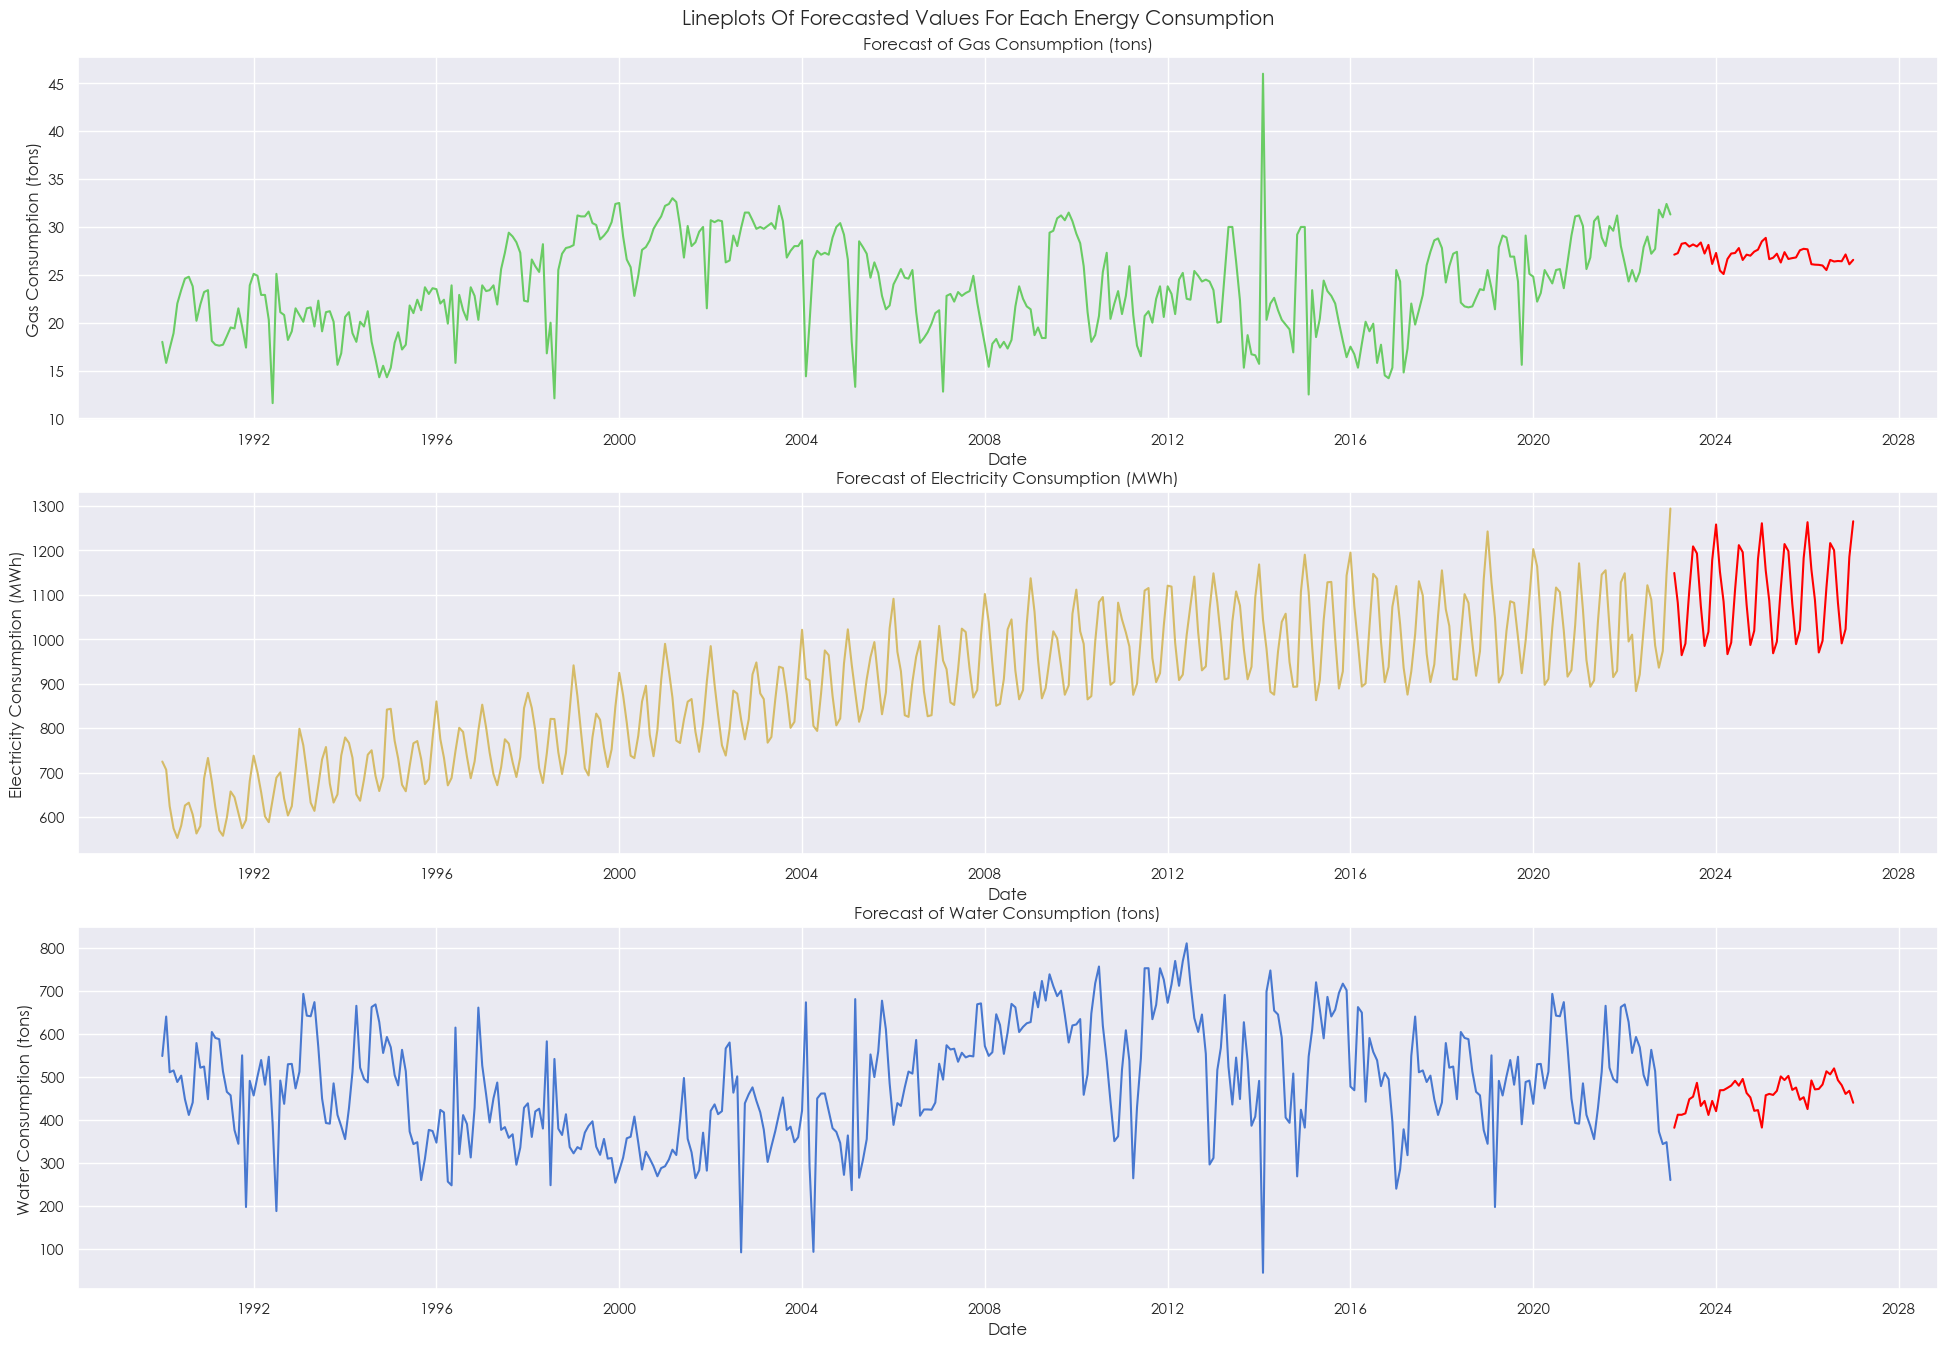

In [55]:
# Forecast steps
steps = 48
# Gas consumption 
order = (3,0,3)
seasonal_order = (5,1,3,12)
sarimax = SARIMAX(endog=energy['Gas Consumption (tons)'],order=order,seasonal_order=seasonalorder,freq='MS').fit()
# Forecast and store values
gas_forecast = sarimax.forecast(steps=steps)
# Electricity consumption
final_expo = ExponentialSmoothing(energy['Electricity Consumption (MWh)'],
                                  damped_trend=damp,
                                  trend=trend,
                                  seasonal=seasonal,
                                  seasonal_periods=seasonal_periods,
                                  freq=freq,
                                  use_boxcox=boxcox,
                                  missing='raise').fit()
electricity_forecast = final_expo.forecast(steps=steps)
# Water consumption
order = (2,0,4)
seasonal_order = (5,1,4,12)
sarimax = SARIMAX(endog=energy['Water Consumption (tons)'],order=order,seasonal_order=seasonalorder,freq='MS').fit()
# Forecast and store values
water_forecast = sarimax.forecast(steps=steps)
# Store all forecasted values 
forecasted_list = [gas_forecast,electricity_forecast,water_forecast]
columns = ['Gas Consumption (tons)','Electricity Consumption (MWh)','Water Consumption (tons)']
# Loop and plot each forecast lineplot
fig,axs = plt.subplots(3,1,figsize=(24,16))
for x in range(len(columns)):
    sns.lineplot(energy[columns[x]],ax=axs[x],color=color[x])
    sns.lineplot(forecasted_list[x],ax=axs[x],color='red').set(title='Forecast of ' + columns[x])
fig.suptitle('Lineplots Of Forecasted Values For Each Energy Consumption',y=0.91)
plt.show()

**ANALYSIS FROM FORECASTING FUTURE VALUES:**

With our final models for each consumption, we were able to forecast future values past the current data we have, and even though they may not be as accurate, these forecasts and models built would be a stepping stone to further improve models in the future.

## **7. CONCLUSION**

In conclusion, time series models such as SARIMAX and Holt-Winters Exponential Smoothing were identified as the best models for the prediction and forecast of gas and water, and electricity respectively when compared to the test data to evaluate the strength of the model. Moreover, we can also see that the final models were able to forecast future values past the test data, however the model still faces limitations which could possibly be overcome by having more data be collected for training and prediction. Overall, even though the models still made errors, significant improvements were still made from hyperparameter tuning and fine-tuning the models, and these models built would be a stepping stone to better and more accurate models in the future. 

<p style='text-align:center; font-size:30px;'><b>-END-</p>